# State Independent Bayesian Optimization: 
- Sina Dabiri 


In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
# plt.style.use('dark_background')
import GPy
from sklearn.metrics import mean_squared_error

In [2]:
path = "Mark_4sec_CA3PSD_ISO_freqamp_020619.csv"

In [3]:
class state_dr_gp:
    '''
    A class to run a Gaussian Process model. 
    
    
    '''
    def gp_model(self, csv_path):
        # Import datasets as pandas
        CA1_df = pd.read_csv(path)

        # Get frequency and amplitudes
        U1 = CA1_df.iloc[:,  0:2]
        # Get the coordinate of pre stimulation gamma 
        X0_coords = np.arange(33,52)

        # sum of pre stimulation gamma
        data = np.sum(CA1_df.iloc[:, X0_coords], axis=1)
        X0_psd = pd.DataFrame(data=data, columns=['sum_preStim_gamma'])
        X0_psd = X0_psd*1e10 # Need values >0 for GP model
        N_trials = np.size(X0_psd, axis=0)
        lower_bound = np.min(U1, axis=0)
        upper_bound = np.max(U1, axis=0)
        # sum of post stimulation gamma         
        X1_coords = np.arange(133,152)
        X1 = np.sum(CA1_df.iloc[:, X1_coords],axis=1)
        X1 = np.array(X1)
        X1 =X1[:, np.newaxis] # reshape
        X1 = X1*1e10 # bring to >0 range        

        return X0_coords, U1, X1, lower_bound, upper_bound, X0_psd, N_trials;
    
    def apply_data_mask(self, U1_X0, X1, n_used_samples):
        # n_used_samples = 100; 
        scale = .1
        f_thresh = 25; g_thresh = 3
        U1_X0_sel = U1_X0[1:n_used_samples]
        X1_sel = np.squeeze(X1[1:n_used_samples])

        X1_thresh = np.squeeze(np.array(U1_X0_sel['sum_preStim_gamma'] > g_thresh, dtype = bool))
        # U1_thresh = U1_X0_sel['Stim_1'] > f_thresh
        sc= 1+scale*np.sin(np.array(U1_X0_sel.Stim_1)*0.1)*(1/(1+np.exp(-(np.array(U1_X0_sel['sum_preStim_gamma'])-2.5))))

        #X1_sel[X1_thresh] = np.multiply(X1_sel[X1_thresh],sc)
        X1_sel = np.multiply(X1_sel,sc)
        #display( np.multiply(X1_sel[X1_thresh],sc))
        X1_sel = X1_sel.reshape(-1,1)
    
        return U1_X0_sel, X1_sel;

    # initialize_data_dr_sim() function
    def initialize_data_dr_sim(self, U1, X0_psd, X1, kernel, slice_dim, ylabel):
       
        # input_data
        # U1_X0 = U1.join(X0_psd)
        
        # create simple GP model
        m = GPy.models.GPRegression(U1,X1,kernel)
        figure = GPy.plotting.plotting_library().figure(2, 1, figsize=(7,8))
        canvas = m.plot(figure=figure, visible_dims=[0,1],row=(1),legend=False, xlabel='Stim. Freq.', ylabel='Stim. Amp.',
                      title="before Optimization");
        display(canvas);
        ax = plt.gca()
        PCM = ax.get_children()[0]
        plt.colorbar(PCM, ax=ax);
        
        # optimize and plot
        m.optimize(messages=True,max_f_eval = 1000);
        canvas = m.plot(figure=figure, visible_dims=[0,1],row=(2), legend=False, xlabel='Stim. Freq.' , ylabel='Stim. Amp.', 
                        title='After Optimization');
        display(canvas)
        ax = plt.gca()
        PCM = ax.get_children()[0]
        plt.colorbar(PCM, ax=ax)
        
        # Plotting slices of the model at amplitudes of 0, 10, and 50
        slices = [0, 10, 50]
        figure = GPy.plotting.plotting_library().figure(3, 1, figsize=(5,10))

        for i, y in zip(range(3), slices):
            print((1,y));

            canvas = m.plot(figure=figure, fixed_inputs=[(slice_dim, y)], row=(i+1), plot_data=True, legend=False,
                            xlabel='Stim. Freq.', ylabel=ylabel, title=("Slices at: ", y));

        display(canvas);
            
        return U1, X1, m; 
    
    
    #Sample Function
    def sample(self,testX, m):

        posteriorTestY = np.empty((100))
        simY  = np.empty((100))
        simMse = np.empty((100))

        state_est = m.posterior_samples_f(testX, full_cov=True, size=1)[:,0,0]
        simY, simMse = m.predict(testX)

        # print("mean is: \n",simY[0],"\n\n Variance is: \n", simMse[0])
        # # posteriorTestY
        # print(np.shape(posteriorTestY),'\n',posteriorTestY[0:10])
        # print(np.shape(simY),'\n', np.shape(simMse))

        return state_est, simY, simMse;
    
    # Acquisition Function
    def acquisition_function(self, simY, simMse, nu, t):
        # Upper Confidence Bound implementation
        #  if d=2 and delta=2
        tau_t = 2*np.log(t**2*(np.pi)**2/6)
        
        ucb = simY+(np.sqrt(nu*tau_t))*simMse
        
        return ucb
    
    # The next step training and bayes_opt_update_state() function
    def bayes_opt_update_state(self, U1, X1, ker_BaO):
         # create simple GP model
        trained_model_BaO = GPy.models.GPRegression(U1,X1,ker_BaO);
        trained_model_BaO.optimize(messages=False,max_f_eval = 1000);
        
        return trained_model_BaO
    
    
    def transition_state(self, U1, X0_psd, state_est, testX):
        state_data_dr = X0_psd
        current_state = np.append(X0_psd, state_est[:,0:1], axis=0)
#         testX_shape_row, testX_shape_col = np.shape(testX)
        
#         current_state = np.empty(())
        
        return current_state
        
    

In [4]:
model = state_dr_gp()

In [5]:
# Get the input U1 and X0_psd, and the X1 outputs
X0_coords, U1, X1, lower_bound, upper_bound, X0_psd, N_trials = model.gp_model(path)

In [6]:
n_all_samples = np.shape(U1)[0]
n_used_samples = 100
n_burn_in = 20
n_samples= 150
n_acquisition = 100
n_parameters_optimizing = 2 # here we are optimizing freq. and amp.
n_all_parameters = 3 # freq amp and preStimGamma
n_exp_runs = 30
n_samples_to_remember = 20
print(n_used_samples)
print(np.shape(X0_psd.iloc[0:n_used_samples]))
print(np.shape(U1.iloc[0:n_used_samples]), np.shape(X1[0:n_used_samples,:]))
# print(U1)
# print(X1)

100
(100, 1)
(100, 2) (100, 1)


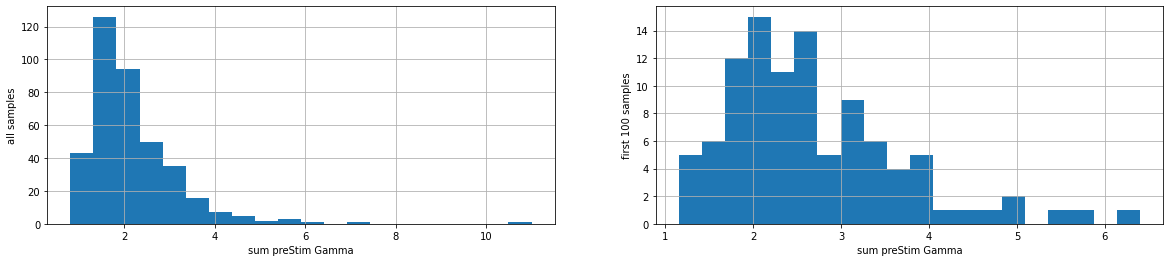

In [7]:
# histogram of raw PSD of preStim gamma
fig = plt.figure(figsize=(20,4));
plt.subplot(1,2,1)
plt.hist(X0_psd, bins=20);
plt.xlabel("sum preStim Gamma")
plt.ylabel("all samples")
plt.grid(visible=True)

plt.subplot(1,2,2)
plt.hist(X0_psd[0:n_used_samples], bins=20);
plt.xlabel("sum preStim Gamma")
plt.ylabel(f"first {'{0:d}'.format(n_used_samples)} samples")
plt.grid(visible=True)
plt.show();

In [8]:
# Balancing Anastesia and Awake samples
# input_data
U1_X0 = U1.join(X0_psd)

U1_X0_sel = U1_X0[1:n_used_samples]
X1_sel = X1[1:n_used_samples]

# def apply_data_mask(U1_X0, X1, n_used_samples):
#     # n_used_samples = 100; 
#     scale = .1
#     f_thresh = 25; g_thresh = 3
#     U1_X0_sel = U1_X0[0:n_used_samples]
#     X1_sel = np.squeeze(X1[0:n_used_samples])
    
#     X1_thresh = np.squeeze(np.array(U1_X0_sel['sum_preStim_gamma'] > g_thresh, dtype = bool))
#     # U1_thresh = U1_X0_sel['Stim_1'] > f_thresh
#     sc= 1+scale*np.sin(np.array(U1_X0_sel.Stim_1)*0.1)*(1/(1+np.exp(-(np.array(U1_X0_sel['sum_preStim_gamma'])-2.5))))
    
#     #X1_sel[X1_thresh] = np.multiply(X1_sel[X1_thresh],sc)
#     X1_sel = np.multiply(X1_sel,sc)
#     #display( np.multiply(X1_sel[X1_thresh],sc))
#     X1_sel = X1_sel.reshape(-1,1)
    
#     return U1_X0_sel, X1_sel


U1_X0_sel, X1_sel = model.apply_data_mask(U1_X0, X1, n_used_samples)
display(U1_X0_sel)
display(np.shape(X1_sel))

,Stim_1,Stim_2,sum_preStim_gamma
1,42,40,2.425945
2,35,30,3.117866
3,23,50,2.868627
4,42,50,3.521665
5,35,50,1.384478
...,...,...,...
95,35,20,3.700448
96,17,20,1.337936
97,5,10,1.672055
98,17,30,3.179625


(99, 1)

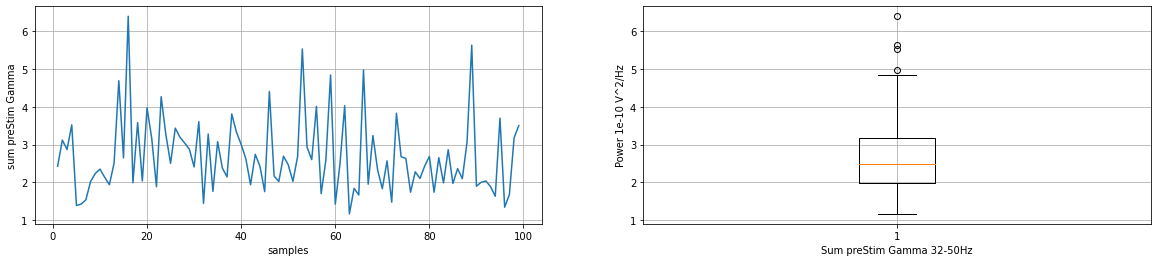

In [9]:
fig = plt.figure(figsize=(20,4));
plt.subplot(1,2,1)
plt.plot(np.arange(1, n_used_samples), U1_X0_sel['sum_preStim_gamma']);
plt.xlabel("samples")
plt.ylabel("sum preStim Gamma")
plt.grid(visible=True)

plt.subplot(1,2,2)
plt.boxplot(U1_X0_sel['sum_preStim_gamma']);
plt.xlabel("Sum preStim Gamma 32-50Hz")
plt.ylabel("Power 1e-10 V^2/Hz")
plt.grid(visible=True)

plt.show();

In [10]:
hill_sum_preStim_gamma = np.empty((n_acquisition))
min_sum_preStim_gamma = np.min(X0_psd['sum_preStim_gamma'])
first_quartile_sum_preStim_gamma = np.quantile(X0_psd['sum_preStim_gamma'], 0.25)
third_quartile_sum_preStim_gamma = np.quantile(X0_psd['sum_preStim_gamma'], 0.75)
# max_sum_preStim_gamma = np.max(X0_psd['sum_preStim_gamma'])
print("min preStimGamma is: \n", min_sum_preStim_gamma, " \n 3rd Quartile preStimGamma is:", 
      third_quartile_sum_preStim_gamma)
half_n_samples = int(n_acquisition/2)
step_size = np.round((third_quartile_sum_preStim_gamma-first_quartile_sum_preStim_gamma)/half_n_samples,6)
# hill_sum_preStim_gamma[0:half_n_samples] = np.arange(min_sum_preStim_gamma, third_quartile_sum_preStim_gamma, step_size)
# hill_sum_preStim_gamma[half_n_samples:n_acquisition] = np.arange(third_quartile_sum_preStim_gamma,
#                                                                      min_sum_preStim_gamma, -step_size)
hill_sum_preStim_gamma[0:half_n_samples] = np.linspace(first_quartile_sum_preStim_gamma, third_quartile_sum_preStim_gamma, half_n_samples)
hill_sum_preStim_gamma[half_n_samples:n_acquisition] = np.flip(np.linspace(first_quartile_sum_preStim_gamma, third_quartile_sum_preStim_gamma, half_n_samples))

print(hill_sum_preStim_gamma[0:3], np.shape(hill_sum_preStim_gamma))

min preStimGamma is: 
 0.8137995193089469  
 3rd Quartile preStimGamma is: 2.5742740008887974
[1.52262311 1.54408538 1.56554764] (100,)


In [11]:
X0_psd_sampled = X0_psd.iloc[1:n_used_samples]
display(X0_psd_sampled['sum_preStim_gamma'])
display(U1_X0_sel['sum_preStim_gamma'])

1     2.425945
2     3.117866
3     2.868627
4     3.521665
5     1.384478
        ...   
95    3.700448
96    1.337936
97    1.672055
98    3.179625
99    3.502282
Name: sum_preStim_gamma, Length: 99, dtype: float64

1     2.425945
2     3.117866
3     2.868627
4     3.521665
5     1.384478
        ...   
95    3.700448
96    1.337936
97    1.672055
98    3.179625
99    3.502282
Name: sum_preStim_gamma, Length: 99, dtype: float64

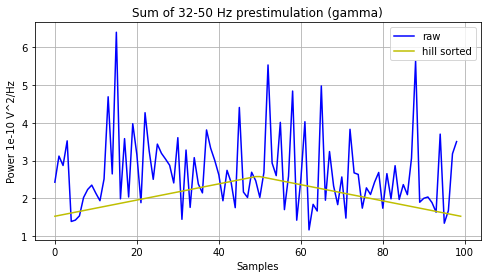

In [12]:
fig = plt.figure(figsize=(8,4));
# plt.plot(np.arange(0, n_used_samples), X0_psd_sampled['sum_preStim_gamma'], color='g');
plt.plot(np.arange(0, n_acquisition-1), U1_X0_sel['sum_preStim_gamma'][0:n_acquisition], color='b');

plt.plot(np.arange(0, n_acquisition), hill_sum_preStim_gamma, color='y');
plt.xlabel("Samples")
plt.ylabel("Power 1e-10 V^2/Hz")
plt.legend(['raw', 'hill sorted'])
plt.title("Sum of 32-50 Hz prestimulation (gamma)")
plt.grid(visible=True)

In [14]:
print('freq, amplitude and preStim gamma used are: \n', U1_X0_sel[0:4])

freq, amplitude and preStim gamma used are: 
    Stim_1  Stim_2  sum_preStim_gamma
1      42      40           2.425945
2      35      30           3.117866
3      23      50           2.868627
4      42      50           3.521665


In [15]:
print(np.shape(U1_X0_sel))

(99, 3)


## 1.2 First BaO Model is trained on all of the dataset

In [158]:
# ker_RBF = GPy.kern.RBF(input_dim=n_all_parameters, variance=3., lengthscale=2.,ARD=True) + GPy.kern.White(2)
ker_BaO = GPy.kern.Matern52(input_dim=n_all_parameters, variance=400., lengthscale=10.,ARD=True) + GPy.kern.White(2)

In [159]:
slice_dim = 1
ylabel='Predicted Gamma'

#### 1.2.1: The first model uses sum_preStim_gamma.

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x22555505520>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x225571d8fd0>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s02  0003   3.172457e+02   1.279373e+01 
    00s09  0011   2.975099e+02   2.211173e-02 
    00s10  0012   2.973486e+02   2.475174e-03 
    00s19  0025   2.972791e+02   2.999571e-02 
    00s24  0033   2.972559e+02   4.950445e-10 
Runtime:     00s24
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x225571c5310>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x2255713d520>]}

(1, 1)
(1, 50)
(1, 100)


{'dataplot': [<matplotlib.collections.PathCollection at 0x225586051f0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x225585e7070>]}

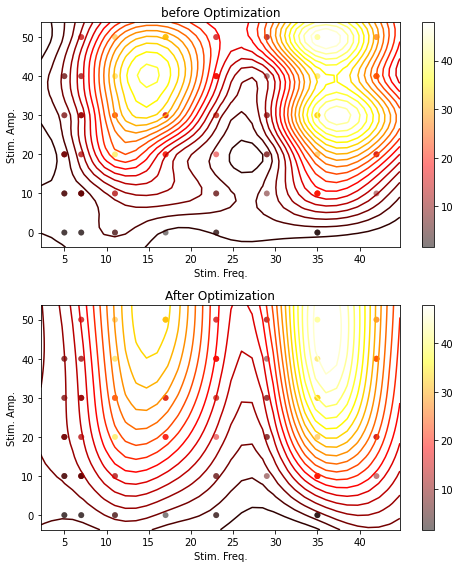

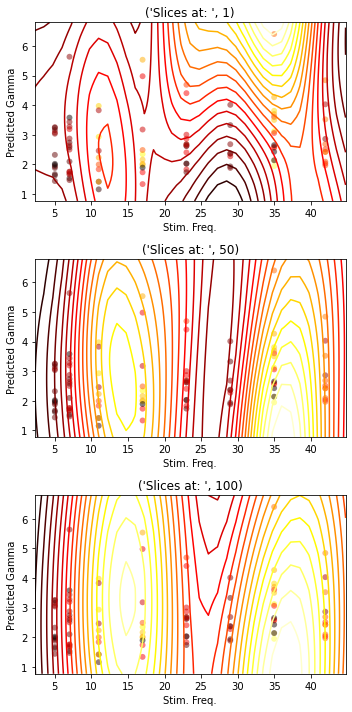

In [160]:
# x_BaO, y_BaO, trained_model_BaO = model.initialize_data_dr_sim(U1, X0_psd, X1, ker_BaO, slice_dim, ylabel)

# create simple GP model
trained_model_BaO = GPy.models.GPRegression(U1_X0_sel,X1_sel,ker_BaO)
figure = GPy.plotting.plotting_library().figure(2, 1, figsize=(7,8))
canvas = trained_model_BaO.plot(figure=figure, visible_dims=[0,1],row=(1),legend=False, xlabel='Stim. Freq.', ylabel='Stim. Amp.',
              title="before Optimization");
display(canvas);
ax = plt.gca()
PCM = ax.get_children()[0]
plt.colorbar(PCM, ax=ax);

# optimize and plot
trained_model_BaO.optimize(messages=True,max_f_eval = 1000);
canvas_optimized = trained_model_BaO.plot(figure=figure, visible_dims=[0,1],row=(2), legend=False, xlabel='Stim. Freq.' , ylabel='Stim. Amp.', 
                title='After Optimization');
display(canvas_optimized)
ax = plt.gca()
PCM = ax.get_children()[0]
plt.colorbar(PCM, ax=ax)

# Plotting slices of the model at amplitudes of 0, 10, and 50
slices = [1, 50, 100]
figure = GPy.plotting.plotting_library().figure(3, 1, figsize=(5,10))

for i, y in zip(range(3), slices):
    print((1,y));

    canvas_slices = trained_model_BaO.plot(figure=figure, fixed_inputs=[(slice_dim, y)], row=(i+1), plot_data=True, legend=False,
                    xlabel='Stim. Freq.', ylabel=ylabel, title=("Slices at: ", y));

display(canvas_slices);

15.808712081298593

15.965170813060581

15.808712081298593

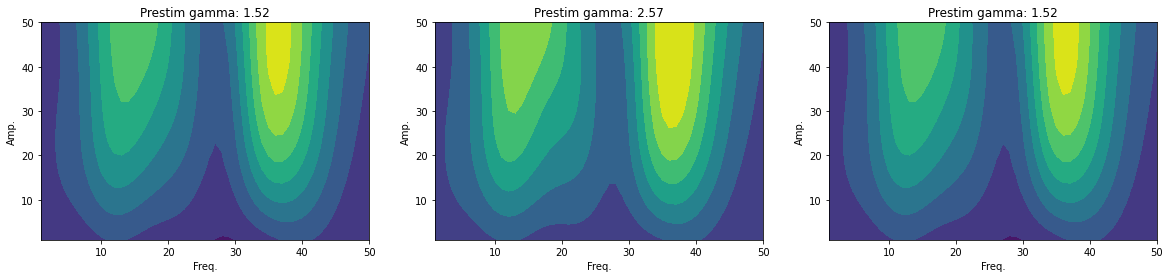

In [161]:
sim_optparam_test = np.full([len(hill_sum_preStim_gamma),2], np.nan)

#pts_surf = [0,24,49]
pts_surf = [0,50,99]

fig = plt.figure(figsize = (20,4))

X_grid1 = np.arange(1,51)
X_grid2 = np.arange(1,51)
X_grid_mesh = np.meshgrid(X_grid1, X_grid2)
X_grid = np.concatenate((np.asarray(X_grid_mesh[0]).reshape(-1,1), np.asarray(X_grid_mesh[1]).reshape(-1,1)),axis = 1)

counter = 1
for a in range(0, n_acquisition):
    
    # print("acquisition #: ", a)
    temp = np.full([len(X_grid),1], hill_sum_preStim_gamma[a])
    
    X_pred = np.concatenate((X_grid, temp), axis = 1)
    simY_BaO_AF = np.empty((1, n_samples))
    simMse_BaO_AF = np.empty((1, n_samples))
    simY_BaO_AF, simMse_BaO_AF= trained_model_BaO.predict(X_pred);
                             
    argMax_model = simY_BaO_AF.argmax()
    # sim_optparam_test[a,:] = np.append(testX[argMax_model],hill_sum_preStim_gamma[a:a+1], axis=0)
    sim_optparam_test[a,:] = X_grid[argMax_model]
    
    if a in pts_surf:
        #ax = fig.add_subplot(1,3,counter,projection='3d')
        ax = fig.add_subplot(1,3,counter)
        # data = pd.DataFrame(data={'x':X_pred[:,0], 'y':X_pred[:,1], 'z':np.squeeze(simY_BaO_AF)})
        # data = data.pivot(index='x', columns='y', values='z')
        # sns.heatmap(data)
        #ax.scatter(X_pred[:,0],X_pred[:,1],simY_BaO_AF)
        ax.contourf(X_grid1,X_grid2,np.reshape(simY_BaO_AF,(len(X_grid1),len(X_grid2))))
        plt.title(f"Prestim gamma: {'{0:.2f}'.format(hill_sum_preStim_gamma[a])}")
        plt.xlabel('Freq.')
        plt.ylabel('Amp.')
        counter = counter + 1
        
        display(np.mean(simY_BaO_AF))

plt.show()

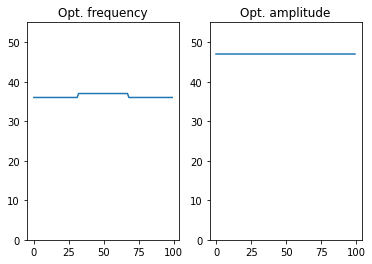

In [162]:
# display(sim_optparam_test)
plt.figure()
plt.subplot(1,2,1)
plt.plot(sim_optparam_test[:,0])
plt.title('Opt. frequency')
plt.ylim([0,55])
plt.subplot(1,2,2)
plt.plot(sim_optparam_test[:,1])
plt.title('Opt. amplitude')
plt.ylim([0,55])
plt.show()

## 1.3: Train the Static model on just the burn-in points, and then use the Acquisition function to pick the next freq/amp 

- The Static model does not use preStimGamma and brain state.
- Then get the suggested freq/amp/preStimGamma from the first model 
- Plot freq/amp/PostStimGamma after 50 interations of acquisition function

In [163]:
# applying data mask

U1_X0 = U1.join(X0_psd)

# U1_X0_sel = U1_X0[0:n_used_samples]
# X1_sel = X1[0:n_used_samples]

U1_X0_sel, X1_sel = model.apply_data_mask(U1_X0, X1, n_used_samples)
U1_sel = U1_X0_sel[['Stim_1','Stim_2']]
display(U1_sel)
display(X1_sel.shape)

,Stim_1,Stim_2
1,42,40
2,35,30
3,23,50
4,42,50
5,35,50
...,...,...
95,35,20
96,17,20
97,5,10
98,17,30


(99, 1)

In [164]:
# chose the first 10 for burn-in/initial training of the model
U1_init = U1_sel.loc[0:n_burn_in,:]
# X0_psd_init = X0_psd.loc[0:n_burn_in-1]
X1_init = X1_sel[0:n_burn_in,:]
print( '\n','freq and amplitude used are: \n', U1_init, np.shape(U1_init))
print('sum postStim gamma are: \n', X1_init, np.shape(X1_init))


 freq and amplitude used are: 
     Stim_1  Stim_2
1       42      40
2       35      30
3       23      50
4       42      50
5       35      50
6       11       0
7        7       0
8       17      30
9       11      50
10      17      50
11      35      30
12       5      40
13      42      20
14      23      30
15       7      50
16      35      10
17      17      50
18       7       0
19      42      20
20      11      40 (20, 2)
sum postStim gamma are: 
 [[28.28259212]
 [35.3155382 ]
 [17.41537359]
 [26.71258011]
 [47.85447968]
 [ 6.13675736]
 [ 3.01429459]
 [28.70903269]
 [30.25154388]
 [36.50382584]
 [40.34110616]
 [ 8.1601432 ]
 [21.91015639]
 [22.44319194]
 [17.26180094]
 [25.97398224]
 [33.03514638]
 [ 1.87336865]
 [18.62013357]
 [33.03904107]] (20, 1)


In [165]:
# input_data
# U1_X0_init = U1_init.join(X0_psd_init)

In [166]:
print(type(U1_init),type(X1_init))

<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>


In [167]:
ker_BaO_AF = GPy.kern.Matern52(input_dim=n_parameters_optimizing, variance=400.,lengthscale=10., ARD=True) + GPy.kern.White(2)
# GPy.kern.RBF(input_dim=n_parameters_optimizing, variance=3., lengthscale=2.,ARD=True) + GPy.kern.White(2)

#### 1.3.1: initial training

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0003   7.697056e+01   3.757989e-01 
    00s04  0008   6.962056e+01   5.100253e-02 
    00s08  0016   6.855612e+01   5.283370e-07 
    00s15  0027   6.854373e+01   3.809396e-05 
    00s18  0032   6.854357e+01   8.741771e-12 
Runtime:     00s18
Optimization status: Converged



 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x225586fc910>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x22558d10370>]}

(1, 1)
(1, 50)
(1, 100)


{'dataplot': [<matplotlib.collections.PathCollection at 0x22557080a60>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x22551261d60>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x225512613d0>]}

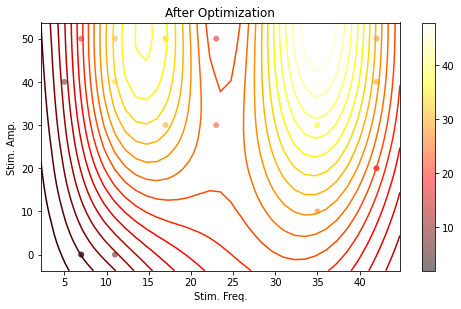

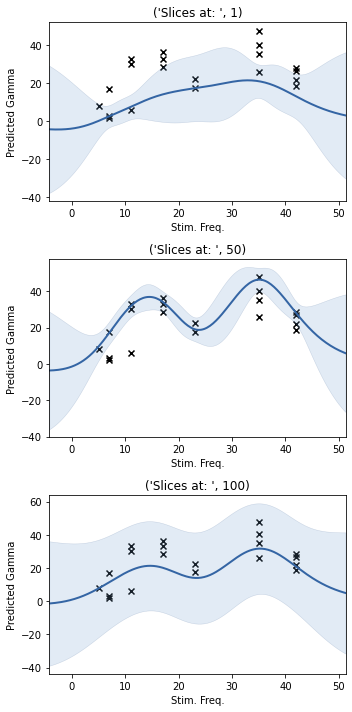

In [168]:
# x_BaO_AF, y_BaO_AF, trained_model_BaO_AF = model.initialize_data_dr_sim(U1_init, X0_psd_init, X1_init, ker_BaO_AF, slice_dim, ylabel)

trained_model_BaO_AF = GPy.models.GPRegression(U1_init,X1_init, ker_BaO_AF)
trained_model_BaO_AF.optimize(messages=True,max_f_eval = 1000);

figure = GPy.plotting.plotting_library().figure(2, 1, figsize=(7,8))
canvas = trained_model_BaO_AF.plot(figure=figure, visible_dims=[0,1],row=(2), legend=False, xlabel='Stim. Freq.' , ylabel='Stim. Amp.', 
                        title='After Optimization');
display(canvas)
ax = plt.gca()
PCM = ax.get_children()[0]
plt.colorbar(PCM, ax=ax)

# Plotting slices of the model at amplitudes of 0, 10, and 50
slices = [1, 50, 100]
figure = GPy.plotting.plotting_library().figure(3, 1, figsize=(5,10))

for i, y in zip(range(3), slices):
    print((1,y));

    canvas = trained_model_BaO_AF.plot(figure=figure, fixed_inputs=[(slice_dim, y)], row=(i+1), plot_data=True, legend=False,
                    xlabel='Stim. Freq.', ylabel=ylabel, title=("Slices at: ", y));

display(canvas);

In [169]:
print(trained_model_BaO_AF.kern.Mat52.lengthscale.values)
print(trained_model_BaO_AF.kern.Mat52.variance.values[0])

[10.17042869 65.4570121 ]
437.19277059999496


#### 1.3.2: Use the acquisition function to guide the next freq to optimize at

In [170]:
rand_freq_1d = np.random.choice([5, 7, 11, 17, 23, 29, 35, 42], size=(50))
rand_freq_1d_sorted = np.sort(rand_freq_1d)
print(rand_freq_1d_sorted, np.shape(rand_freq_1d_sorted))
rand_amp_1d = np.random.choice([10, 20, 30, 40, 50], size=(50))
rand_amp_1d_sorted = np.sort(rand_amp_1d)
print(rand_amp_1d_sorted, np.shape(rand_amp_1d_sorted))
rand_time_1d = np.random.choice(np.arange(0,384),size=(50))
print(rand_time_1d, rand_time_1d.shape)
X_grid_mesh = np.meshgrid(rand_freq_1d_sorted, rand_amp_1d_sorted)
X_grid = np.concatenate((np.asarray(X_grid_mesh[0]).reshape(-1,1), np.asarray(X_grid_mesh[1]).reshape(-1,1)),axis = 1)

X_grid_mesh_t = np.meshgrid(rand_freq_1d_sorted, rand_amp_1d_sorted, rand_time_1d)
X_grid_t = np.concatenate((np.asarray(X_grid_mesh_t[0]).reshape(-1,1), np.asarray(X_grid_mesh_t[1]).reshape(-1,1), np.asarray(X_grid_mesh_t[2]).reshape(-1,1)),axis = 1)
print(np.shape(X_grid), X_grid_t.shape)

[ 5  5  7  7  7  7  7  7 11 11 11 17 17 17 17 17 17 17 17 17 17 17 17 17
 23 23 23 23 23 29 29 29 29 29 29 35 35 35 35 35 35 35 42 42 42 42 42 42
 42 42] (50,)
[10 10 10 10 10 10 10 10 10 10 10 20 20 20 20 30 30 30 30 30 30 30 30 30
 30 40 40 40 40 40 40 40 40 40 40 40 50 50 50 50 50 50 50 50 50 50 50 50
 50 50] (50,)
[209 281  64  93 107 100 350 277 156 145  47 240 236 144 110 156  19 209
   9  68   7 374 197   3 306  59 138 134 265 275 274 383  92  63 156 299
 275 239  14 251 247  96  26  59 193 216 340 287 367 133] (50,)
(2500, 2) (125000, 3)


In [171]:
# print(np.shape(rand_freq_1d_sorted), np.shape(rand_amp_1d_sorted))

# testX_BaO = np.array([rand_freq_1d_sorted, rand_amp_1d_sorted])
# print(np.shape(testX_BaO))
# testX = np.transpose(testX_BaO)
testX = X_grid
print(np.shape(testX))

(2500, 2)


In [172]:
def static_BaO_func(n_samples, n_all_parameters, n_acquisition, testX, hill_sum_preStim_gamma, trained_model_BaO, trained_model_BaO_AF, U1_init, 
                     X1_init, ker_BaO_AF):

    # a loop to optimize at every acquistion for 50 iteration and re-optimization, then plot before and after.
    ucb = np.empty((1, n_samples))
    ucb_sample = np.empty((n_acquisition, n_all_parameters))
    postStimGamma_predicted_from_simulation = np.empty((n_acquisition, 1))
    postStimGamma_predicted_from_simulation_static = np.empty((n_acquisition, 1))
    # print(np.shape(ucb))
    model_sample_static = np.empty((n_acquisition, n_all_parameters))

    nu = 0.1
    # print("nu set at: ", nu)
    static_lengthscale = np.empty((n_parameters_optimizing, n_acquisition))
    static_variance = np.empty((n_acquisition, 1))
    for a in range(0, n_acquisition):
        # print("acquisition #: ", a)
        simY_BaO_AF = np.empty((1, n_samples))
        simMse_BaO_AF = np.empty((1, n_samples))
        simY_BaO_AF, simMse_BaO_AF= trained_model_BaO_AF.predict(testX);

        argMax_model = simY_BaO_AF.argmax()
        model_sample_static[a,:] = np.append(testX[argMax_model],hill_sum_preStim_gamma[a:a+1], axis=0)
        model_sample_static_reshaped = np.reshape(model_sample_static[a,:], (1,n_all_parameters))
        # print("Simulation model prediction: ", model_sample_static_reshaped)

        ucb= model.acquisition_function(simY_BaO_AF, simMse_BaO_AF, nu, 1)
        max_ucb = np.max(ucb, axis=0)
        argMax_ucb = ucb.argmax()
        # find the values of argMax_ucb in the sample grid
        ucb_sample[a,:] = np.append(testX[argMax_ucb],hill_sum_preStim_gamma[a:a+1], axis=0)
        ucb_sample_reshaped = np.reshape(ucb_sample[a,:], (1,n_all_parameters))
        # print("Static model prediction: ", ucb_sample_reshaped)

        # Predicting the Acquisition Func. suggest next freq/amp/preStimGamma from the frist model
        postStimGamma_predicted_from_simulation[a] = trained_model_BaO.posterior_samples_f(model_sample_static_reshaped, full_cov=True, size=1)[:,0,0]
        postStimGamma_predicted_from_simulation_static[a] = trained_model_BaO.posterior_samples_f(ucb_sample_reshaped, full_cov=True, size=1)[:,0,0]
        # simY_BaO, simMse_BaO =  trained_model_BaO.predict(ucb_sample_reshaped);

        # append the acquisition function suggested, and first model predicted mean freq/amp/preStimGamma and mean postStimGamma from state_est_BaO to the burn-in points
        next_sample_to_optimize = pd.DataFrame({'Stim_1':[int(ucb_sample[a,0])], 'Stim_2':[int(ucb_sample[a,1])]})
        U1_init = pd.concat([U1_init, next_sample_to_optimize], ignore_index=True, keys=['Stim_1','Stim_2'], axis=0)

        # Concatenate the first model predicted postStimGamma 
        next_postStimGamma = np.empty((1,1))
        next_postStimGamma[0,:] = [postStimGamma_predicted_from_simulation_static[a]]
        X1_init = np.append(X1_init, next_postStimGamma, axis=0)

        # trained_model_BaO_AF.add_observer()
        trained_model_BaO_AF = model.bayes_opt_update_state(U1_init, X1_init, ker_BaO_AF);
        static_lengthscale[:,a] = trained_model_BaO_AF.kern.Mat52.lengthscale.values
        static_variance[a] = trained_model_BaO_AF.kern.Mat52.variance.values[0]
        
    return trained_model_BaO_AF, model_sample_static, ucb_sample, postStimGamma_predicted_from_simulation, postStimGamma_predicted_from_simulation_static, static_lengthscale, static_variance

In [173]:
trained_model_BaO_AF, model_sample_static, ucb_sample, postStimGamma_predicted_from_simulation, postStimGamma_predicted_from_simulation_static, static_lengthscale, static_variance = static_BaO_func(
    n_samples, n_all_parameters, n_acquisition, testX, hill_sum_preStim_gamma, trained_model_BaO, trained_model_BaO_AF, U1_init, X1_init, ker_BaO_AF)

#### 1.3.3: Plot before and after optimization 

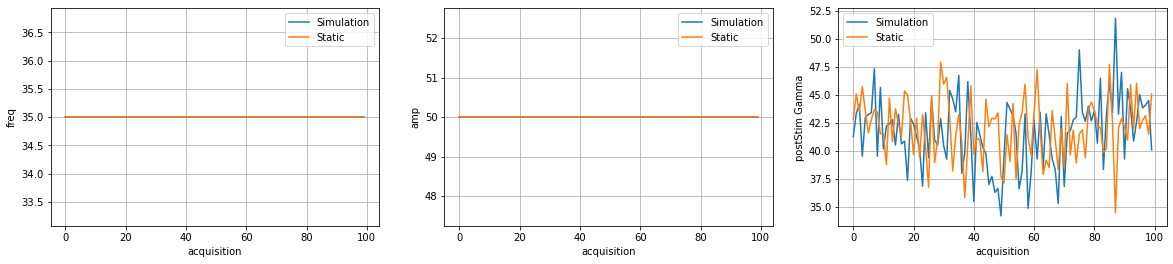

In [174]:
fig = plt.figure(figsize=(20,4));
plt.subplot(1,3,1)
plt.plot(np.arange(0,n_acquisition), model_sample_static[:,0], label=r"frequency")
plt.plot(np.arange(0,n_acquisition), ucb_sample[:,0], label=r"frequency")
plt.xlabel("acquisition")
plt.ylabel("freq")
plt.legend(["Simulation", "Static"])
plt.grid(visible=True)

plt.subplot(1,3,2)
plt.plot(np.arange(0,n_acquisition), model_sample_static[:,1], label=r"amplitude")
plt.plot(np.arange(0,n_acquisition), ucb_sample[:,1], label=r"amplitude")
plt.xlabel("acquisition")
plt.ylabel("amp")
plt.legend(["Simulation", "Static"])
plt.grid(visible=True)

plt.subplot(1,3,3)
plt.plot(np.arange(0,n_acquisition), postStimGamma_predicted_from_simulation, label=r"postStimGamma")
plt.plot(np.arange(0,n_acquisition), postStimGamma_predicted_from_simulation_static, label=r"postStimGamma")
plt.xlabel("acquisition")
plt.ylabel("postStim Gamma")
plt.legend(["Simulation", "Static"])
plt.grid(visible=True)
plt.show();
# plot the model's max (freq, amp, postStim gamma) at each iteration

In [175]:
np.shape(static_lengthscale)

(2, 100)

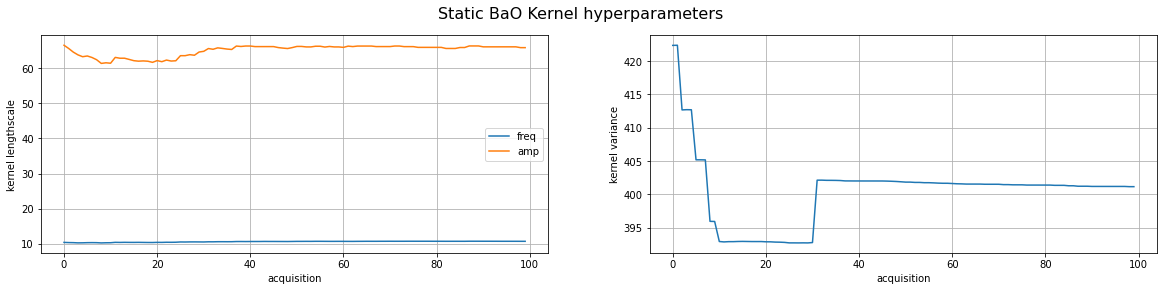

In [176]:
fig = plt.figure(figsize=(20,4));
fig.suptitle("Static BaO Kernel hyperparameters", fontsize=16)
plt.subplot(1,2,1)
plt.plot(np.arange(0,n_acquisition), static_lengthscale[0,:])
plt.plot(np.arange(0,n_acquisition),  static_lengthscale[1,:])
plt.xlabel("acquisition")
plt.ylabel("kernel lengthscale")
plt.legend(["freq", "amp"])
plt.grid(visible=True)

plt.subplot(1,2,2)
plt.plot(np.arange(0,n_acquisition), static_variance)
plt.xlabel("acquisition")
plt.ylabel("kernel variance")
plt.grid(visible=True)

plt.show();

In [177]:
# print(ucb_sample)
print(ucb_sample[1:,0])
print(ucb_sample[1:,1])
# print(ucb_sample[1:,2])

[35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35.
 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35.
 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35.
 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35.
 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35.
 35. 35. 35. 35. 35. 35. 35. 35. 35.]
[50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50.
 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50.
 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50.
 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50.
 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50. 50.
 50. 50. 50. 50. 50. 50. 50. 50. 50.]


In [178]:
print(postStimGamma_predicted_from_simulation_static[1:10])

[[45.07433097]
 [43.48277961]
 [45.73506263]
 [43.54549617]
 [41.59721059]
 [42.79287645]
 [43.67467346]
 [43.42164998]
 [41.52925033]]


### 1.4: Dynamic BaO

In [179]:
dynamic_model = state_dr_gp()

In [180]:
# Get the input U1 and X0_psd, and the X1 outputs
X0_coords, U1_dynamic, X1_dynamic, lower_bound, upper_bound, X0_psd_dynamic, N_trials = dynamic_model.gp_model(path)

In [181]:
U1_X0_dynamic = U1_dynamic.join(X0_psd_dynamic)
U1_X0_dynamic_sel, X1_dynamic_sel = dynamic_model.apply_data_mask(U1_X0_dynamic, X1_dynamic, n_used_samples)
U1_dynamic_sel = U1_X0_dynamic_sel[['Stim_1','Stim_2']]
display(U1_dynamic_sel)
display(X1_dynamic_sel.shape)

,Stim_1,Stim_2
1,42,40
2,35,30
3,23,50
4,42,50
5,35,50
...,...,...
95,35,20
96,17,20
97,5,10
98,17,30


(99, 1)

#### 1.4.1: We will not use preStimGamma, and instead we will train on most recent 20 samples so the model is not affected by brain state changes.

In [182]:
U1_init_dynamic = U1_dynamic_sel.loc[0:n_burn_in,:]
X1_init_dynamic = X1_dynamic_sel[0:n_burn_in,:]
# X0_psd_init_dynamic = X0_psd.loc[0:n_burn_in-1]

print('freq and amplitude used are: \n', U1_init_dynamic, np.shape(U1_init_dynamic))
# print('Sum preStim gamma are: \n', X0_psd_init_dynamic)
print('sum postStim gamma are: \n', X1_init_dynamic, np.shape(X1_init_dynamic))

freq and amplitude used are: 
     Stim_1  Stim_2
1       42      40
2       35      30
3       23      50
4       42      50
5       35      50
6       11       0
7        7       0
8       17      30
9       11      50
10      17      50
11      35      30
12       5      40
13      42      20
14      23      30
15       7      50
16      35      10
17      17      50
18       7       0
19      42      20
20      11      40 (20, 2)
sum postStim gamma are: 
 [[28.28259212]
 [35.3155382 ]
 [17.41537359]
 [26.71258011]
 [47.85447968]
 [ 6.13675736]
 [ 3.01429459]
 [28.70903269]
 [30.25154388]
 [36.50382584]
 [40.34110616]
 [ 8.1601432 ]
 [21.91015639]
 [22.44319194]
 [17.26180094]
 [25.97398224]
 [33.03514638]
 [ 1.87336865]
 [18.62013357]
 [33.03904107]] (20, 1)


In [183]:
ker_BaO_dynamic = GPy.kern.Matern52(input_dim=n_parameters_optimizing, variance=400., lengthscale=10.,ARD=True) + GPy.kern.White(2)
# GPy.kern.RBF(input_dim=n_parameters_optimizing, variance=3., lengthscale=2.,ARD=True) + GPy.kern.White(2)

In [184]:
print(np.shape(U1_init_dynamic))
print(np.shape(X1_init_dynamic))
# print(np.shape(X0_psd_init_dynamic))

(20, 2)
(20, 1)


In [185]:
print(type(U1_init_dynamic),type(X1_init_dynamic))

<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>


#### 1.4.2: Initial training of the Dynamic model

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0002   7.790563e+01   9.957805e-01 
    00s10  0011   6.861127e+01   9.297904e-03 
    00s12  0017   6.855608e+01   3.697204e-06 
    00s19  0030   6.854357e+01   1.778719e-09 
    00s20  0032   6.854357e+01   8.741771e-12 
Runtime:     00s20
Optimization status: Converged



 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x225541cc610>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x2255540b670>]}

(1, 1)
(1, 50)
(1, 100)


{'dataplot': [<matplotlib.collections.PathCollection at 0x22550b81850>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x22550b81ee0>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x225554f5d30>]}

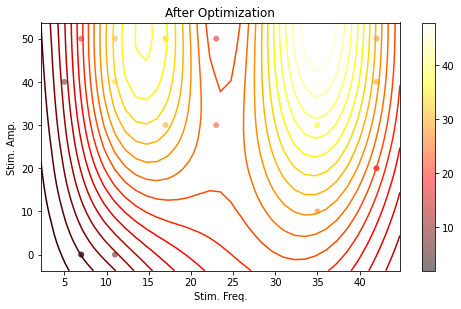

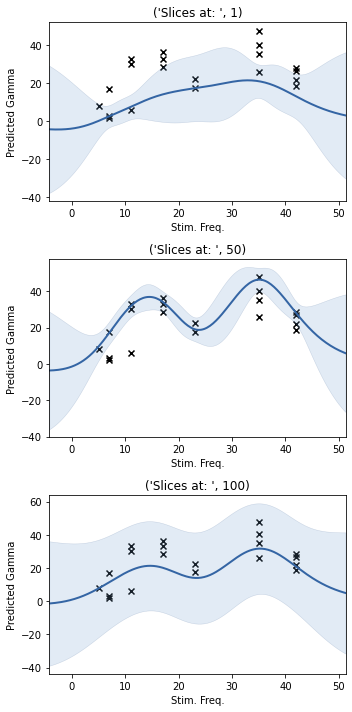

In [186]:
# Initialize a dynamic model:
# x_BaO_dynamic, y_BaO_dynamic, trained_model_BaO_Dynamic = dynamic_model.initialize_data_dr_sim(U1_init_dynamic, X0_psd_init_dynamic, X1_init_dynamic, 
#                                                                                                ker_BaO_dynamic, slice_dim, ylabel)
trained_model_BaO_Dynamic = GPy.models.GPRegression(U1_init_dynamic,X1_init_dynamic, ker_BaO_dynamic)
trained_model_BaO_Dynamic.optimize(messages=True,max_f_eval = 1000);

figure = GPy.plotting.plotting_library().figure(2, 1, figsize=(7,8))
canvas = trained_model_BaO_Dynamic.plot(figure=figure, visible_dims=[0,1],row=(2), legend=False, xlabel='Stim. Freq.' , ylabel='Stim. Amp.', 
                                        title='After Optimization');
display(canvas)
ax = plt.gca()
PCM = ax.get_children()[0]
plt.colorbar(PCM, ax=ax)

# Plotting slices of the model at amplitudes of 0, 10, and 50
slices = [1, 50, 100]
figure = GPy.plotting.plotting_library().figure(3, 1, figsize=(5,10))

for i, y in zip(range(3), slices):
    print((1,y));

    canvas = trained_model_BaO_Dynamic.plot(figure=figure, fixed_inputs=[(slice_dim, y)], row=(i+1), plot_data=True, legend=False,
                    xlabel='Stim. Freq.', ylabel=ylabel, title=("Slices at: ", y));

display(canvas);
# x_BaO_dynamic, y_BaO_dynamic, trained_model_BaO_Dynamic = dynamic_model.initialize_data_dr_sim(U1_init_dynamic, X0_psd_init_dynamic, X1_init_dynamic, 
# ker_BaO, slice_dim, ylabel)

In [187]:
print(np.shape(testX))

(2500, 2)


#### 1.4.3: Using the acquisition function to guide the training of the Dynamic model

In [188]:
def dynamic_BaO_func(n_samples, n_all_parameters, n_acquisition, testX, hill_sum_preStim_gamma, trained_model_BaO, trained_model_BaO_Dynamic, U1_init_dynamic, 
                     X1_init_dynamic, ker_BaO_dynamic):
    
    ucb_dynamic = np.empty((1, n_samples))
    ucb_sample_dynamic = np.empty((n_acquisition, n_all_parameters))
    postStimGamma_predicted_from_simulation_d = np.empty((n_acquisition, 1))
    postStimGamma_predicted_from_simulation_dynamic = np.empty((n_acquisition, 1))
    # print(np.shape(ucb_dynamic))
    model_sample_dynamic = np.empty((n_acquisition, n_all_parameters))

    nu = 0.1
    # print("nu set at: ", nu)
    dynamic_lengthscale = np.empty((n_parameters_optimizing, n_acquisition))
    dynamic_variance = np.empty((n_acquisition, 1))    
    
    for a in range(0, n_acquisition):
        # print("acquisition #: ", a)
        simY_BaO_dynamic = np.empty((1, n_samples))
        simMse_BaO_dynamic = np.empty((1, n_samples))
        simY_BaO_dynamic, simMse_BaO_dynamic= trained_model_BaO_Dynamic.predict(testX);

        argMax_model = simY_BaO_dynamic.argmax()
        model_sample_dynamic[a,:] = np.append(testX[argMax_model],hill_sum_preStim_gamma[a:a+1], axis=0)
        model_sample_dynamic_reshaped = np.reshape(model_sample_dynamic[a,:], (1,n_all_parameters))
        # print("Simulation model prediction: ", model_sample_dynamic_reshaped)    

        ucb_dynamic= dynamic_model.acquisition_function(simY_BaO_dynamic, simMse_BaO_dynamic, nu, 1)
        max_ucb_dynamic = np.max(ucb_dynamic, axis=0)
        argMax_ucb_dynamic = ucb_dynamic.argmax()
        # find the values of argMax_ucb in the sample grid np.append(testX[argMax_ucb],np.zeros([1]), axis=0)
        ucb_sample_dynamic[a, :] = np.append(testX[argMax_ucb_dynamic],hill_sum_preStim_gamma[a:a+1], axis=0)
        ucb_sample_reshaped = np.reshape(ucb_sample_dynamic[a,:], (1,n_all_parameters))
        # print("Dynamic model prediction: ", ucb_sample_reshaped)
        # Predicting the Acquisition Func. suggest next freq/amp/preStimGamma from the frist model
        postStimGamma_predicted_from_simulation_d[a] = trained_model_BaO.posterior_samples_f(model_sample_dynamic_reshaped, full_cov=True, size=1)[:,0,0]
        postStimGamma_predicted_from_simulation_dynamic[a] = trained_model_BaO.posterior_samples_f(ucb_sample_reshaped, full_cov=True, size=1)[:,0,0]
        # print(postStimGamma_predicted_from_simulation_dynamic[a])
        # simY_BaO_dynamic, simMse_BaO_dynamic =  trained_model_BaO_Dynamic.predict(ucb_sample_reshaped);

        # append the acquisition function suggested, and first model predicted mean freq/amp/preStimGamma and mean postStimGamma from state_est_BaO to the burn-in points
        next_sample_to_optimize = pd.DataFrame({'Stim_1':[int(ucb_sample_dynamic[a,0])], 'Stim_2':[int(ucb_sample_dynamic[a,1])]})
        U1_init_dynamic = pd.concat([U1_init_dynamic, next_sample_to_optimize], ignore_index=True, keys=['Stim_1','Stim_2'], axis=0)
        U1_init_dynamic_twenty = U1_init_dynamic.loc[a:a+int(n_samples_to_remember-1),:]

    #     # sum_preStim_gamma
    #     next_preStimGamma_dynamic = pd.DataFrame({'sum_preStim_gamma':[int(ucb_sample_dynamic[a,2])]})
    #     X0_psd_init_dynamic = pd.concat([X0_psd_init_dynamic, next_preStimGamma_dynamic], ignore_index=True, axis=0)
    #     X0_psd_init_dynamic_twenty = X0_psd_init_dynamic.loc[a:a+int(n_burn_in),:]

        # Concatenate the first model predicted postStimGamma 
        next_postStimGamma = np.empty((1,1))
        next_postStimGamma[0,:] = [postStimGamma_predicted_from_simulation_dynamic[a]]
        X1_init_dynamic = np.append(X1_init_dynamic, next_postStimGamma, axis=0)
        # print("X1_init_dynamic shape is: ", np.shape(X1_init_dynamic))

        X1_init_dynamic_twenty = X1_init_dynamic[a:a+int(n_samples_to_remember),:]
        # print(np.shape(U1_init_dynamic_twenty),np.shape(X1_init_dynamic_twenty))
        # trained_model_BaO_AF.add_observer()
        # trained_model_BaO_AF.optimize(messages=True,max_f_eval = 1000)
        trained_model_BaO_Dynamic = dynamic_model.bayes_opt_update_state(U1_init_dynamic_twenty, X1_init_dynamic_twenty, ker_BaO_dynamic)
        dynamic_lengthscale[:,a] = trained_model_BaO_Dynamic.kern.Mat52.lengthscale.values
        dynamic_variance[a] = trained_model_BaO_Dynamic.kern.Mat52.variance.values[0]
        
    return trained_model_BaO_Dynamic, model_sample_dynamic, ucb_sample_dynamic, postStimGamma_predicted_from_simulation_d, postStimGamma_predicted_from_simulation_dynamic, dynamic_lengthscale, dynamic_variance

In [189]:
trained_model_BaO_Dynamic, model_sample_dynamic, ucb_sample_dynamic, postStimGamma_predicted_from_simulation_d, postStimGamma_predicted_from_simulation_dynamic, dynamic_lengthscale, dynamic_variance = dynamic_BaO_func(
    n_samples, n_all_parameters, n_acquisition, testX, hill_sum_preStim_gamma, trained_model_BaO, trained_model_BaO_Dynamic, U1_init_dynamic, X1_init_dynamic, ker_BaO_dynamic)

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\kern\src\stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\kern\src\stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\kern\src\stationary.py:138: RuntimeWarning:invalid value encountered in add
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\kern\src\stationary.py:137: RuntimeWarning:overflow encountered in square


In [190]:
# testX[argMax_ucb_dynamic]
print(np.shape(dynamic_lengthscale))

(2, 100)


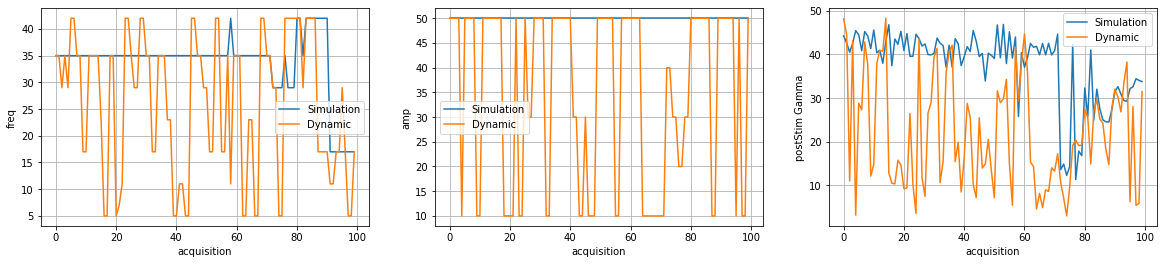

In [191]:
fig = plt.figure(figsize=(20,4));
plt.subplot(1,3,1)
plt.plot(np.arange(0,n_acquisition), model_sample_dynamic[:,0], label=r"frequency")
plt.plot(np.arange(0,n_acquisition), ucb_sample_dynamic[:,0], label=r"frequency")
plt.xlabel("acquisition")
plt.ylabel("freq")
plt.legend(["Simulation", "Dynamic"])
plt.grid(visible=True)

plt.subplot(1,3,2)
plt.plot(np.arange(0,n_acquisition), model_sample_dynamic[0:,1], label=r"amplitude")
plt.plot(np.arange(0,n_acquisition), ucb_sample_dynamic[0:,1], label=r"amplitude")
plt.xlabel("acquisition")
plt.ylabel("amp")
plt.legend(["Simulation", "Dynamic"])
plt.grid(visible=True)

plt.subplot(1,3,3)
plt.plot(np.arange(0,n_acquisition), postStimGamma_predicted_from_simulation_d, label=r"postStimGamma")
plt.plot(np.arange(0,n_acquisition), postStimGamma_predicted_from_simulation_dynamic, label=r"postStimGamma")
plt.xlabel("acquisition")
plt.ylabel("postStim Gamma")
plt.legend(["Simulation", "Dynamic"])
plt.grid(visible=True)
plt.show()

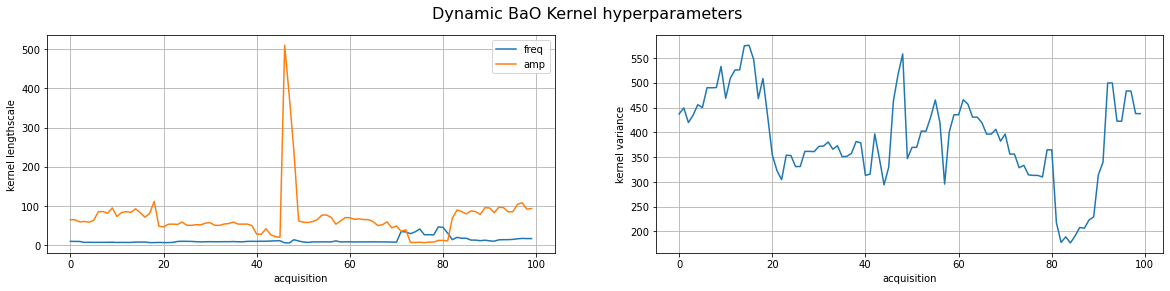

In [192]:
fig = plt.figure(figsize=(20,4));
fig.suptitle("Dynamic BaO Kernel hyperparameters", fontsize=16)
plt.subplot(1,2,1)
plt.plot(np.arange(0,n_acquisition), dynamic_lengthscale[0,:])
plt.plot(np.arange(0,n_acquisition),  dynamic_lengthscale[1,:])
plt.xlabel("acquisition")
plt.ylabel("kernel lengthscale")
plt.legend(["freq", "amp"])
plt.grid(visible=True)

plt.subplot(1,2,2)
plt.plot(np.arange(0,n_acquisition), dynamic_variance)
plt.xlabel("acquisition")
plt.ylabel("kernel variance")
plt.grid(visible=True)

plt.show();

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x2255533aee0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x22555360e80>]}

(1, 1)
(1, 50)
(1, 100)


{'dataplot': [<matplotlib.collections.PathCollection at 0x22558420730>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x22558420dc0>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x22558420fd0>]}

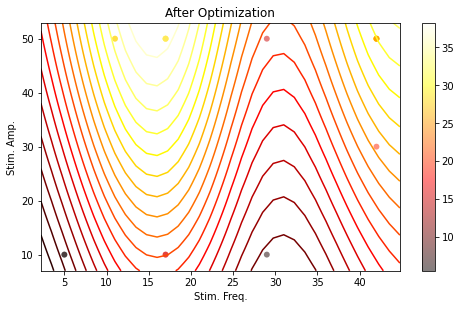

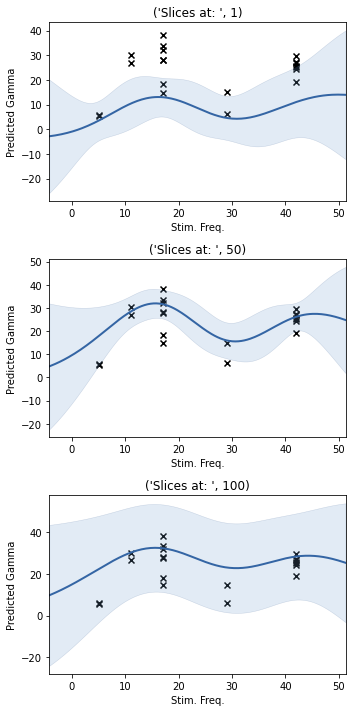

In [193]:
figure = GPy.plotting.plotting_library().figure(2, 1, figsize=(7,8))
canvas = trained_model_BaO_Dynamic.plot(figure=figure, visible_dims=[0,1],row=(2), legend=False, xlabel='Stim. Freq.' , ylabel='Stim. Amp.', 
                        title='After Optimization');
display(canvas)
ax = plt.gca()
PCM = ax.get_children()[0]
plt.colorbar(PCM, ax=ax)

# Plotting slices of the model at amplitudes of 0, 10, and 50
slices = [1, 50, 100]
figure = GPy.plotting.plotting_library().figure(3, 1, figsize=(5,10))

for i, y in zip(range(3), slices):
    print((1,y));

    canvas = trained_model_BaO_Dynamic.plot(figure=figure, fixed_inputs=[(slice_dim, y)], row=(i+1), plot_data=True, legend=False,
                    xlabel='Stim. Freq.', ylabel=ylabel, title=("Slices at: ", y));

display(canvas);

### 1.5: Adaptive BaO

In [194]:
adaptive_model = state_dr_gp()

In [195]:
# Get the input U1 and X0_psd, and the X1 outputs
X0_coords, U1_adaptive, X1_adaptive, lower_bound, upper_bound, X0_psd_adaptive, N_trials = adaptive_model.gp_model(path)

In [196]:
U1_X0_adaptive = U1_adaptive.join(X0_psd_adaptive)
U1_X0_adaptive_sel, X1_adaptive_sel = adaptive_model.apply_data_mask(U1_X0_adaptive, X1_adaptive, n_used_samples)
U1_adaptive_sel = U1_X0_adaptive_sel[['Stim_1','Stim_2']]

In [197]:
time = np.arange(1, n_acquisition)
print(time.shape)
U1_adaptive_sel['time'] = time
print(U1_adaptive_sel.shape)
U1_adaptive_sel

(99,)
(99, 3)


,Stim_1,Stim_2,time
1,42,40,1
2,35,30,2
3,23,50,3
4,42,50,4
5,35,50,5
...,...,...,...
95,35,20,95
96,17,20,96
97,5,10,97
98,17,30,98


In [198]:
U1_init_adaptive = U1_adaptive_sel.loc[0:n_burn_in,:]
X1_init_adaptive = X1_adaptive_sel[0:n_burn_in,:]


In [199]:
print(np.shape(U1_init_adaptive))
print(np.shape(X1_init_adaptive))


(20, 3)
(20, 1)


In [200]:
ker_BaO_adaptive = GPy.kern.Matern52(input_dim=3, variance=400., lengthscale=10.,ARD=True) + GPy.kern.White(3)

#### 1.5.1: Initial Training of the Adaptive Model

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s09  0008   7.020476e+01   2.311806e-04 
    00s19  0019   6.994335e+01   2.872889e-03 
    00s56  0050   6.854434e+01   1.229317e-09 
Runtime:     00s56
Optimization status: Converged



 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x22555a78d60>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x225554716d0>]}

(1, 1)
(1, 50)
(1, 100)


{'dataplot': [<matplotlib.collections.PathCollection at 0x2255845e460>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x2255842e820>]}

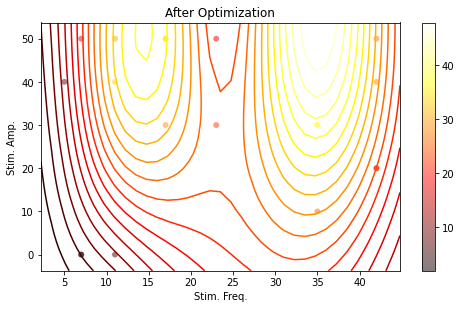

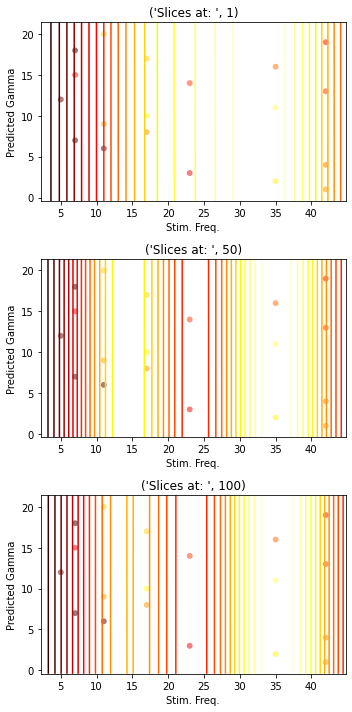

In [201]:
# Initialize the adaptive model:

trained_model_BaO_adaptive = GPy.models.GPRegression(U1_init_adaptive,X1_init_adaptive, ker_BaO_adaptive)
trained_model_BaO_adaptive.optimize(messages=True,max_f_eval = 1000);

figure = GPy.plotting.plotting_library().figure(2, 1, figsize=(7,8))
canvas = trained_model_BaO_adaptive.plot(figure=figure, visible_dims=[0,1],row=(2), legend=False, xlabel='Stim. Freq.' , ylabel='Stim. Amp.', 
                                        title='After Optimization');
display(canvas)
ax = plt.gca()
PCM = ax.get_children()[0]
plt.colorbar(PCM, ax=ax)

# Plotting slices of the model at amplitudes of 0, 10, and 50
slices = [1, 50, 100]
figure = GPy.plotting.plotting_library().figure(3, 1, figsize=(5,10))

for i, y in zip(range(3), slices):
    print((1,y));

    canvas = trained_model_BaO_adaptive.plot(figure=figure, fixed_inputs=[(slice_dim, y)], row=(i+1), plot_data=True, legend=False,
                    xlabel='Stim. Freq.', ylabel=ylabel, title=("Slices at: ", y));

display(canvas);

#### 1.5.2: Using the acquisition function to guide the training of the Adaptive model

In [202]:
# making a testX with time
testX_t=X_grid_t
testX_t.shape
print(n_all_parameters)
n_all_parameters_t = 4
print(n_all_parameters_t)
n_parameters_optimizing_t = 3

3
4


In [203]:
def adaptive_BaO_func(n_samples, n_all_parameters, n_acquisition, testX, hill_sum_preStim_gamma, trained_model_BaO, trained_model_BaO_adaptive, U1_init_adaptive, 
                     X1_init_adaptive, ker_BaO_adaptive):
    
    ucb_adaptive = np.empty((1, n_samples))
    ucb_sample_adaptive = np.empty((n_acquisition, n_all_parameters))
    postStimGamma_predicted_from_simulation_a = np.empty((n_acquisition, 1))
    postStimGamma_predicted_from_simulation_adaptive = np.empty((n_acquisition, 1))
    model_sample_adaptive = np.empty((n_acquisition, n_all_parameters))

    nu = 0.1
    # print("nu set at: ", nu)
    adaptive_lengthscale = np.empty((n_parameters_optimizing_t, n_acquisition))
    adaptive_variance = np.empty((n_acquisition, 1))    
    
    for a in range(0, n_acquisition):
        # print("acquisition #: ", a)
        simY_BaO_adaptive = np.empty((1, n_samples))
        simMse_BaO_adaptive = np.empty((1, n_samples))
        simY_BaO_adaptive, simMse_BaO_adaptive = trained_model_BaO_adaptive.predict(testX);

        argMax_model = simY_BaO_adaptive.argmax()
        model_sample_adaptive[a,:] = np.append(testX[argMax_model],hill_sum_preStim_gamma[a:a+1], axis=0)
        model_sample_adaptive_reshaped = np.reshape(model_sample_adaptive[a,:], (1,n_all_parameters))    

        ucb_adaptive = adaptive_model.acquisition_function(simY_BaO_adaptive, simMse_BaO_adaptive, nu, 1)
        max_ucb_adaptive = np.max(ucb_adaptive, axis=0)
        argMax_ucb_adaptive = ucb_adaptive.argmax()
        # find the values of argMax_ucb in the sample grid np.append(testX[argMax_ucb],np.zeros([1]), axis=0)
        ucb_sample_adaptive[a, :] = np.append(testX[argMax_ucb_adaptive],hill_sum_preStim_gamma[a:a+1], axis=0)
        ucb_sample_reshaped = np.reshape(ucb_sample_adaptive[a,:], (1,n_all_parameters))
     
        # Predicting the Acquisition Func. suggest next freq/amp/preStimGamma from the frist model
        postStimGamma_predicted_from_simulation_a[a] = trained_model_BaO.posterior_samples_f(model_sample_adaptive_reshaped, full_cov=True, size=1)[:,0,0]
        postStimGamma_predicted_from_simulation_adaptive[a] = trained_model_BaO.posterior_samples_f(ucb_sample_reshaped, full_cov=True, size=1)[:,0,0]

        # append the acquisition function suggested, and first model predicted mean freq/amp/preStimGamma and mean postStimGamma from state_est_BaO to the burn-in points
        next_sample_to_optimize = pd.DataFrame({'Stim_1':[int(ucb_sample_adaptive[a,0])], 'Stim_2':[int(ucb_sample_adaptive[a,1])], 'time':[int(ucb_sample_adaptive[a,2])]})
        U1_init_adaptive = pd.concat([U1_init_adaptive, next_sample_to_optimize], ignore_index=True, keys=['Stim_1','Stim_2','time'], axis=0)
        # U1_init_adaptive_twenty = U1_init_adaptive.loc[a:a+int(n_samples_to_remember-1),:]

        # Concatenate the first model predicted postStimGamma 
        next_postStimGamma = np.empty((1,1))
        next_postStimGamma[0,:] = [postStimGamma_predicted_from_simulation_adaptive[a]]
        X1_init_adaptive = np.append(X1_init_adaptive, next_postStimGamma, axis=0)

        # X1_init_adaptive_twenty = X1_init_adaptive[a:a+int(n_samples_to_remember),:]
        trained_model_BaO_adaptive = adaptive_model.bayes_opt_update_state(U1_init_adaptive, X1_init_adaptive, ker_BaO_adaptive)
        adaptive_lengthscale[:,a] = trained_model_BaO_adaptive.kern.Mat52.lengthscale.values
        adaptive_variance[a] = trained_model_BaO_adaptive.kern.Mat52.variance.values[0]
        
    return trained_model_BaO_adaptive, model_sample_adaptive, ucb_sample_adaptive, postStimGamma_predicted_from_simulation_a, postStimGamma_predicted_from_simulation_adaptive, adaptive_lengthscale, adaptive_variance

In [204]:
trained_model_BaO_adaptive, model_sample_adaptive, ucb_sample_adaptive, postStimGamma_predicted_from_simulation_a, postStimGamma_predicted_from_simulation_adaptive, adaptive_lengthscale, adaptive_variance = adaptive_BaO_func(
    n_samples, n_all_parameters_t, n_acquisition, testX_t, hill_sum_preStim_gamma, trained_model_BaO, trained_model_BaO_adaptive, U1_init_adaptive, X1_init_adaptive, ker_BaO_adaptive)

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\kern\src\stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\kern\src\stationary.py:137: RuntimeWarning:overflow encountered in square
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\kern\src\stationary.py:138: RuntimeWarning:invalid value encountered in add
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\kern\src\stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


### 1.6: comparing static and adaptive BaO

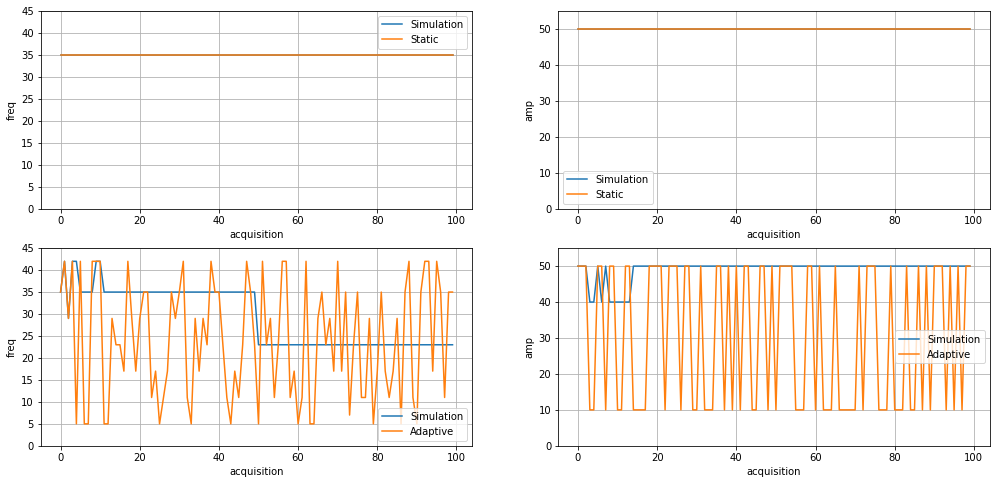

In [205]:
fig = plt.figure(figsize=(17,8));
fig.title = ("Simulation vs. Static/Dynamic BaO")
plt.subplot(2,2,1)
plt.plot(np.arange(0,n_acquisition), model_sample_static[:,0], label=r"frequency")
plt.plot(np.arange(0,n_acquisition), ucb_sample[:,0], label=r"frequency")
plt.ylim([0, 45])
plt.xlabel("acquisition")
plt.ylabel("freq")
plt.legend(["Simulation", "Static"])
plt.grid(visible=True)

plt.subplot(2,2,2)
plt.plot(np.arange(0,n_acquisition), model_sample_static[:,1], label=r"amplitude")
plt.plot(np.arange(0,n_acquisition), ucb_sample[:,1], label=r"amplitude")
plt.ylim([0, 55])
plt.xlabel("acquisition")
plt.ylabel("amp")
plt.legend(["Simulation", "Static"])
plt.grid(visible=True)

plt.subplot(2,2,3)
plt.plot(np.arange(0,n_acquisition), model_sample_adaptive[:,0], label=r"frequency")
plt.plot(np.arange(0,n_acquisition), ucb_sample_adaptive[:,0], label=r"frequency")
plt.ylim([0, 45])
plt.xlabel("acquisition")
plt.ylabel("freq")
plt.legend(["Simulation", "Adaptive"])
plt.grid(visible=True)

plt.subplot(2,2,4)
plt.plot(np.arange(0,n_acquisition), model_sample_adaptive[:,1], label=r"amplitude")
plt.plot(np.arange(0,n_acquisition), ucb_sample_adaptive[:,1], label=r"amplitude")
plt.ylim([0, 55])
plt.xlabel("acquisition")
plt.ylabel("amp")
plt.legend(["Simulation", "Adaptive"])
plt.grid(visible=True)

plt.show()


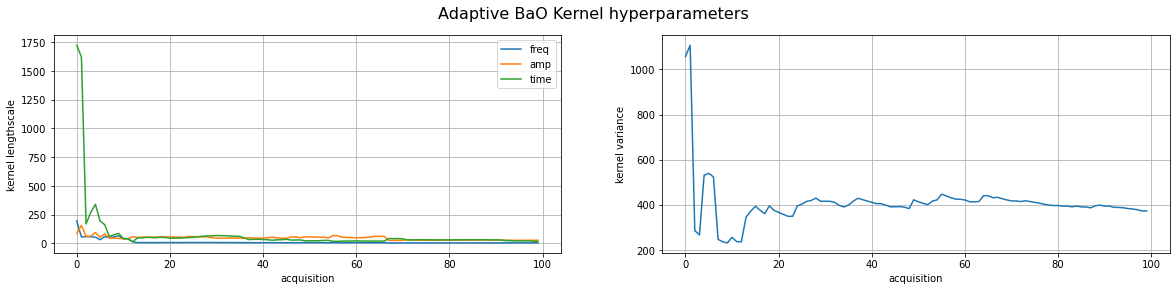

In [206]:
fig = plt.figure(figsize=(20,4));
fig.suptitle("Adaptive BaO Kernel hyperparameters", fontsize=16)
plt.subplot(1,2,1)
plt.plot(np.arange(0,n_acquisition), adaptive_lengthscale[0,:])
plt.plot(np.arange(0,n_acquisition), adaptive_lengthscale[1,:])
plt.plot(np.arange(0,n_acquisition), adaptive_lengthscale[2,:])
plt.xlabel("acquisition")
plt.ylabel("kernel lengthscale")
plt.legend(["freq", "amp","time"])
plt.grid(visible=True)

plt.subplot(1,2,2)
plt.plot(np.arange(0,n_acquisition), adaptive_variance)
plt.xlabel("acquisition")
plt.ylabel("kernel variance")
plt.grid(visible=True)

plt.show();

### 1.7: Experiment Loop 

In [64]:
print(np.shape(model_sample_static))

(100, 3)


In [207]:
# Initialize variables:
# reshape variables
static_sample = np.empty((n_acquisition, n_all_parameters, n_exp_runs))
dynamic_sample = np.empty((n_acquisition, n_all_parameters, n_exp_runs))
adaptive_sample = np.empty((n_acquisition, n_all_parameters_t, n_exp_runs))
simulation_postStimGamma_predicted = np.empty((n_acquisition, 1, n_exp_runs))
static_postStimGamma_predicted = np.empty((n_acquisition, 1, n_exp_runs))

static_ucb = np.empty((n_acquisition, n_all_parameters, n_exp_runs))
dynamic_ucb = np.empty((n_acquisition, n_all_parameters, n_exp_runs))
adaptive_ucb = np.empty((n_acquisition, n_all_parameters_t, n_exp_runs))
simulation_postStimGamma_predicted_d = np.empty((n_acquisition, 1, n_exp_runs))
dynamic_postStimGamma_predicted = np.empty((n_acquisition, 1, n_exp_runs))
simulation_postStimGamma_predicted_a = np.empty((n_acquisition, 1, n_exp_runs))
adaptive_postStimGamma_predicted = np.empty((n_acquisition, 1, n_exp_runs))

static_lengthscale = np.empty((n_parameters_optimizing, n_acquisition, n_exp_runs))
static_variance = np.empty((n_acquisition, 1, n_exp_runs))
dynamic_lengthscale = np.empty((n_parameters_optimizing, n_acquisition, n_exp_runs))
dynamic_variance = np.empty((n_acquisition, 1, n_exp_runs))
adaptive_lengthscale = np.empty((n_parameters_optimizing_t, n_acquisition, n_exp_runs))
adaptive_variance = np.empty((n_acquisition, 1, n_exp_runs))

for e in range(0, n_exp_runs): #n_exp_runs
    print('Experiment run: ', e)
    
#     Initial training for satic: trained_model_BaO_AF, ker_BaO_AF
    U1_init = U1_sel.loc[0:n_burn_in,:]
    X1_init = X1_sel[0:n_burn_in,:]
    ker_BaO_AF = GPy.kern.Matern52(input_dim=n_parameters_optimizing, variance=400., lengthscale=10.,ARD=True) + GPy.kern.White(2)
    trained_model_BaO_AF = GPy.models.GPRegression(U1_init,X1_init, ker_BaO_AF)
    trained_model_BaO_AF.optimize(messages=True,max_f_eval = 1000);
    
    U1_init_dynamic = U1_dynamic_sel.loc[0:n_burn_in,:]
    X1_init_dynamic = X1_dynamic_sel[0:n_burn_in,:]
    ker_BaO_dynamic = GPy.kern.Matern52(input_dim=n_parameters_optimizing, variance=400., lengthscale=10.,ARD=True) + GPy.kern.White(2)
    trained_model_BaO_Dynamic = GPy.models.GPRegression(U1_init_dynamic,X1_init_dynamic, ker_BaO_dynamic)
    trained_model_BaO_Dynamic.optimize(messages=True,max_f_eval = 1000);
    
    U1_init_adaptive = U1_adaptive_sel.loc[0:n_burn_in,:]
    X1_init_adaptive = X1_adaptive_sel[0:n_burn_in,:]
    ker_BaO_adaptive = GPy.kern.Matern52(input_dim=n_parameters_optimizing_t, variance=400., lengthscale=10.,ARD=True) + GPy.kern.White(3)
    trained_model_BaO_adaptive = GPy.models.GPRegression(U1_init_adaptive,X1_init_adaptive, ker_BaO_adaptive)
    trained_model_BaO_adaptive.optimize(messages=True,max_f_eval = 1000);
    
    _, static_sample[:,:,e], static_ucb[:,:,e], simulation_postStimGamma_predicted[:,:,e], static_postStimGamma_predicted[:,:,e], static_lengthscale[:,:,e], static_variance[:,0:1,e] = static_BaO_func(
        n_samples, n_all_parameters, n_acquisition, testX, hill_sum_preStim_gamma, trained_model_BaO, trained_model_BaO_AF, U1_init, X1_init, ker_BaO_AF)
    
    _, dynamic_sample[:,:,e], dynamic_ucb[:,:,e], simulation_postStimGamma_predicted_d[:,:,e], dynamic_postStimGamma_predicted[:,:,e], dynamic_lengthscale[:,:,e], dynamic_variance[:,0:1,e]  = dynamic_BaO_func(
        n_samples, n_all_parameters, n_acquisition, testX, hill_sum_preStim_gamma, trained_model_BaO, trained_model_BaO_Dynamic, U1_init_dynamic, X1_init_dynamic, ker_BaO_dynamic)
    
    _, adaptive_sample[:,:,e], adaptive_ucb[:,:,e], simulation_postStimGamma_predicted_a[:,:,e], adaptive_postStimGamma_predicted[:,:,e], adaptive_lengthscale[:,:,e], adaptive_variance[:,0:1,e]  = adaptive_BaO_func(
        n_samples, n_all_parameters_t, n_acquisition, testX_t, hill_sum_preStim_gamma, trained_model_BaO, trained_model_BaO_adaptive, U1_init_adaptive, X1_init_adaptive, ker_BaO_adaptive)
        
    print('end of run. \n ----------------------------------------')

Experiment run:  0
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s04  0006   7.192734e+01   2.520095e-01 
    00s07  0010   6.867259e+01   1.581253e-02 
    00s11  0015   6.855612e+01   5.485068e-07 
    00s23  0032   6.854357e+01   8.741771e-12 
Runtime:     00s23
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0005   7.383643e+01   1.159867e-01 
    00s05  0009   6.898347e+01   4.990648e-02 
    00s06  0010   6.867259e+01   1.581253e-02 
    00s14  0020   6.855539e+01   1.512141e-04 
    00s19  0024   6.856904e+01   7.834589e-03 
    00s24  0032   6.854357e+01   8.741771e-12 
Runtime:     00s24
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0004   7.465773e+01   7.476354e-02 
    00s05  0011   7.262063e+01   7.096242e-02 
    00s19  0023   6.948963e+01   1.2868

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\kern\src\stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\kern\src\stationary.py:137: RuntimeWarning:overflow encountered in square
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\kern\src\stationary.py:138: RuntimeWarning:invalid value encountered in add
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\kern\src\stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


end of run. 
 ----------------------------------------
Experiment run:  1
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s02  0003   7.697056e+01   3.757989e-01 
    00s05  0008   6.962056e+01   5.100253e-02 
    00s10  0017   6.855608e+01   3.697204e-06 
    00s16  0028   6.854359e+01   6.391245e-07 
    00s19  0032   6.854357e+01   8.741771e-12 
Runtime:     00s19
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s05  0008   6.962056e+01   5.100253e-02 
    00s07  0010   6.867259e+01   1.581253e-02 
    00s10  0016   6.855612e+01   5.283370e-07 
    00s17  0027   6.854373e+01   3.809396e-05 
    00s21  0032   6.854357e+01   8.741771e-12 
Runtime:     00s21
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0001   8.223638e+01   3.338119e-01 
    00s04  0005   7.051228e+01 

##### 1.7.1: plots for Std Dev and Mean

In [208]:
static_variance.shape
static_lengthscale.shape

(2, 100, 30)

In [209]:
# calculate mean and std dev for the experiment runs
static_sample_mean = np.mean(static_sample,axis=2)
print(np.shape(static_sample_mean),'\n', static_sample_mean[0:3,:])
dynamic_sample_mean = np.mean(dynamic_sample, axis=2)
adaptive_sample_mean = np.mean(adaptive_sample, axis=2)

static_ucb_mean = np.mean(static_ucb, axis=2)
print(np.shape(static_ucb_mean),'\n', static_ucb_mean[0:3,:])
dynamic_ucb_mean = np.mean(dynamic_ucb, axis=2)
adaptive_ucb_mean = np.mean(dynamic_ucb, axis=2)

static_sample_std = np.std(static_sample, axis=2)
print(np.shape(static_sample_std),'\n', static_sample_std[0:3,:])
dynamic_sample_std = np.std(dynamic_sample, axis=2)
adaptive_sample_std = np.std(adaptive_sample, axis=2)

static_ucb_std = np.std(static_ucb, axis=2)
dynamic_ucb_std = np.std(dynamic_ucb, axis=2)
adaptive_ucb_std = np.std(dynamic_ucb, axis=2)

static_lengthscale_mean = np.mean(static_lengthscale, axis=2)
print(np.shape(static_lengthscale_mean),'\n', static_lengthscale_mean[0:3,0:3])
dynamic_lengthscale_mean = np.mean(dynamic_lengthscale, axis=2)
adaptive_lengthscale_mean = np.mean(adaptive_lengthscale, axis=2)

static_variance_mean = np.mean(static_variance, axis=2)
print(np.shape(static_variance_mean),'\n', static_variance_mean[0:3,0:3])
dynamic_variance_mean = np.mean(dynamic_variance, axis=2)
adaptive_variance_mean = np.mean(adaptive_variance, axis=2)

static_lengthscale_std = np.std(static_lengthscale, axis=2)
print(np.shape(static_lengthscale_std),'\n', static_lengthscale_std[0:3,0:3])
dynamic_lengthscale_std = np.std(dynamic_lengthscale, axis=2)
adaptive_lengthscale_std = np.std(adaptive_lengthscale, axis=2)

static_variance_std = np.std(static_variance, axis=2)
print(np.shape(static_variance_std),'\n', static_variance_std[0:3,0:3])
dynamic_variance_std = np.std(dynamic_variance, axis=2)
adaptive_variance_std = np.std(adaptive_variance, axis=2)

(100, 3) 
 [[35.         50.          1.52262311]
 [35.         50.          1.54408538]
 [35.         50.          1.56554764]]
(100, 3) 
 [[35.         50.          1.52262311]
 [34.6        50.          1.54408538]
 [35.         50.          1.56554764]]
(100, 3) 
 [[0.00000000e+00 0.00000000e+00 2.22044605e-16]
 [0.00000000e+00 0.00000000e+00 4.44089210e-16]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]]
(2, 100) 
 [[10.3368067  10.32245867 10.3677701 ]
 [66.09214172 66.83875062 67.22730776]]
(100, 1) 
 [[426.3816369 ]
 [422.24740774]
 [419.92622169]]
(2, 100) 
 [[0.25992761 0.6718391  0.61283872]
 [1.88485405 1.92286849 1.68519797]]
(100, 1) 
 [[8.60766152]
 [9.55050577]
 [9.50283037]]


In [210]:
# Std Dev bar plots:
std_dev_ucb_df = pd.DataFrame({"Freq. (S)": static_ucb_std[:,0],
                               "Amp. (S)": static_ucb_std[:,1],
                                "Freq. (D)": dynamic_ucb_std[:,0],
                                "Amp. (D)": dynamic_ucb_std[:,1],
                                "Freq. (A)": adaptive_ucb_std[:,0],
                                "Amp. (A)": adaptive_ucb_std[:,1]})
display(std_dev_ucb_df.head())

,Freq. (S),Amp. (S),Freq. (D),Amp. (D),Freq. (A),Amp. (A)
0,0.000000,0.0,0.0,0.00000,0.0,0.00000
1,1.496663,0.0,0.0,0.00000,0.0,0.00000
2,0.000000,0.0,2.4,0.00000,2.4,0.00000
3,0.000000,0.0,2.4,7.18022,2.4,7.18022
4,1.077033,0.0,2.4,0.00000,2.4,0.00000


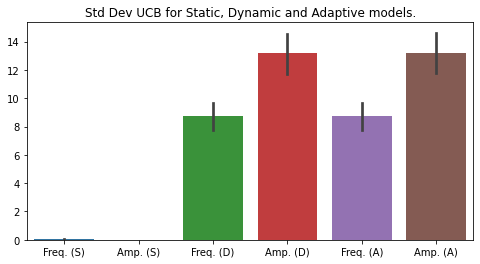

In [211]:
fig = plt.figure(figsize=(8,4));
sns.barplot(data=std_dev_ucb_df); 
plt.title("Std Dev UCB for Static, Dynamic and Adaptive models.");
plt.show();


In [212]:
std_dev_sim_df = pd.DataFrame({"Sim. Freq. (S)": static_sample_std[:,0],
                               "Sim. Amp. (S)": static_sample_std[:,1],
                               "Simu. Freq. (D)": dynamic_sample_std[:,0],
                               "Sim. Amp. (D)": dynamic_sample_std[:,1],
                               "Simu. Freq. (A)": adaptive_sample_std[:,0],
                               "Sim. Amp. (A)": adaptive_sample_std[:,1]})
display(std_dev_sim_df.head())

,Sim. Freq. (S),Sim. Amp. (S),Simu. Freq. (D),Sim. Amp. (D),Simu. Freq. (A),Sim. Amp. (A)
0,0.0,0.0,0.0,0.0,0.000000,0.000000
1,0.0,0.0,0.0,0.0,3.492214,5.259911
2,0.0,0.0,0.0,0.0,3.683145,3.726780
3,0.0,0.0,0.0,0.0,3.505710,3.000000
4,0.0,0.0,0.0,0.0,3.207803,3.000000


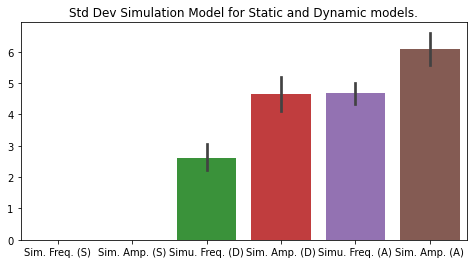

In [213]:
fig = plt.figure(figsize=(8,4));
sns.barplot(data=std_dev_sim_df); 
plt.title("Std Dev Simulation Model for Static and Dynamic models.");
plt.show();

In [214]:
# Mean UCB:
mean_ucb_df = pd.DataFrame({"Freq. (S)": static_ucb_mean[:,0],
                            "Amp. (S)": static_ucb_mean[:,1],
                            "Freq. (D)": dynamic_ucb_mean[:,0],
                            "Amp. (D)": dynamic_ucb_mean[:,1],
                            "Freq. (A)": adaptive_ucb_mean[:,0],
                            "Amp. (A)": adaptive_ucb_mean[:,1]})
display(mean_ucb_df.head())

,Freq. (S),Amp. (S),Freq. (D),Amp. (D),Freq. (A),Amp. (A)
0,35.0,50.0,35.0,50.000000,35.0,50.000000
1,34.6,50.0,35.0,50.000000,35.0,50.000000
2,35.0,50.0,33.8,50.000000,33.8,50.000000
3,35.0,50.0,33.8,48.666667,33.8,48.666667
4,34.8,50.0,30.2,50.000000,30.2,50.000000


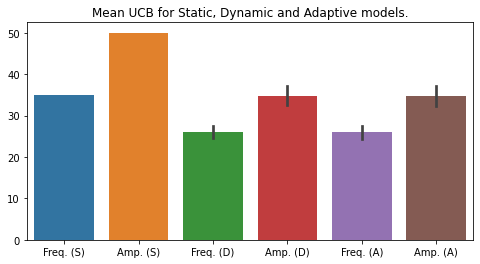

In [215]:
fig = plt.figure(figsize=(8,4));
sns.barplot(data=mean_ucb_df); 
plt.title("Mean UCB for Static, Dynamic and Adaptive models.");
plt.show();

In [216]:
# Mean Simulatino Model:
mean_sim_df = pd.DataFrame({"Freq. (S)": static_sample_mean[:,0],
                            "Amp. (S)": static_sample_mean[:,1],
                            "Freq. (D)": dynamic_sample_mean[:,0],
                            "Amp. (D)": dynamic_sample_mean[:,1],
                            "Freq. (A)": adaptive_sample_mean[:,0],
                            "Amp. (A)": adaptive_sample_mean[:,1]})
display(mean_sim_df.head())

,Freq. (S),Amp. (S),Freq. (D),Amp. (D),Freq. (A),Amp. (A)
0,35.0,50.0,35.0,50.0,35.000000,50.000000
1,35.0,50.0,35.0,50.0,38.266667,47.000000
2,35.0,50.0,35.0,50.0,37.366667,48.333333
3,35.0,50.0,35.0,50.0,36.900000,49.000000
4,35.0,50.0,35.0,50.0,37.100000,49.000000


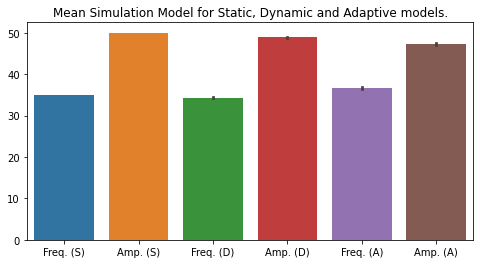

In [217]:
fig = plt.figure(figsize=(8,4));
sns.barplot(data=mean_sim_df); 
plt.title("Mean Simulation Model for Static, Dynamic and Adaptive models.");
plt.show();

##### 1.7.2: Acquisition plots

 C:\Users\sinad\AppData\Local\Temp\ipykernel_69996\1034292043.py:15: UserWarning:The handle <matplotlib.collections.PolyCollection object at 0x00000225583EEDF0> has a label of '_Hidden' which cannot be automatically added to the legend.
 C:\Users\sinad\AppData\Local\Temp\ipykernel_69996\1034292043.py:15: UserWarning:The handle <matplotlib.collections.PolyCollection object at 0x00000225583EE3D0> has a label of '_Hidden' which cannot be automatically added to the legend.


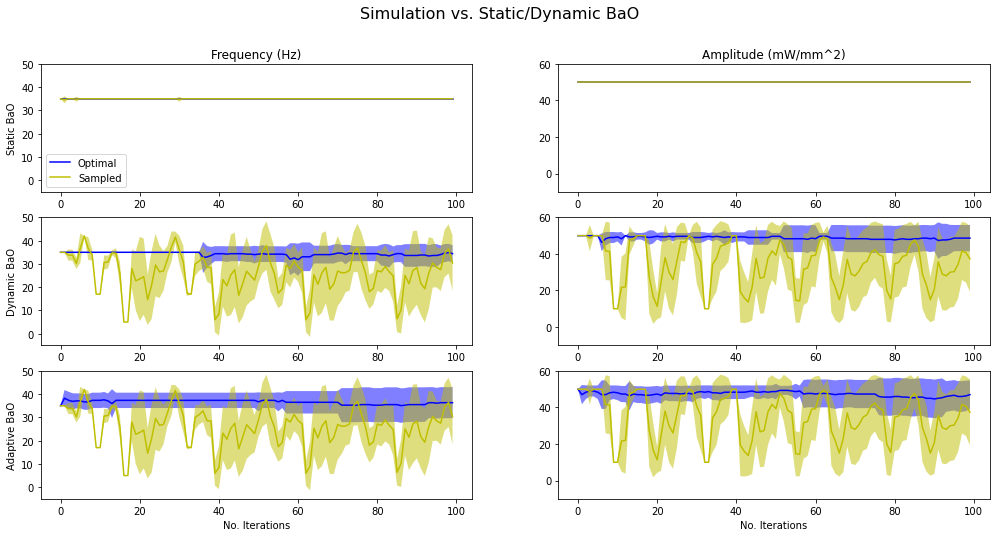

In [218]:
x_acquisitions = np.arange(0,n_acquisition)
fig = plt.figure(figsize=(17,8));
fig.suptitle("Simulation vs. Static/Dynamic BaO", fontsize=16)
plt.subplot(3,2,1)
plt.plot(x_acquisitions, static_sample_mean[:,0], label=r"frequency", color='b')
plt.fill_between(x_acquisitions, static_sample_mean[:,0]+static_sample_std[:,0],
                static_sample_mean[:,0]-static_sample_std[:,0], alpha=0.5, facecolor='b', label='_Hidden')
plt.plot(x_acquisitions, static_ucb_mean[:,0], label=r"frequency", color='y')
plt.fill_between(x_acquisitions, static_ucb_mean[:,0]+static_ucb_std[:,0],
                static_ucb_mean[:,0]-static_ucb_std[:,0], alpha=0.5, facecolor='y', label='_Hidden')
plt.ylim([-5, 50])
# plt.xlabel("No. Iterations")
plt.ylabel("Static BaO")
plt.title("Frequency (Hz)")
plt.legend(["Optimal", "_Hidden", "Sampled", "_Hidden"]);
# plt.grid(visible=True)

plt.subplot(3,2,2)
plt.plot(x_acquisitions, static_sample_mean[:,1], label=r"amplitude", color='b')
plt.fill_between(x_acquisitions, static_sample_mean[:,1]+static_sample_std[:,1],
                static_sample_mean[:,1]-static_sample_std[:,1], alpha=0.5, facecolor='b', label='_Hidden')
plt.plot(x_acquisitions, static_ucb_mean[:,1], label=r"amplitude", color='y')
plt.fill_between(x_acquisitions, static_ucb_mean[:,1]+static_ucb_std[:,1],
                static_ucb_mean[:,1]-static_ucb_std[:,1], alpha=0.5, facecolor='y', label='_Hidden')
plt.ylim([-10, 60])
# plt.xlabel("No. Iterations")
plt.title("Amplitude (mW/mm^2)")
# plt.legend(["Simulation", '_Hidden', "Static", '_Hidden']);
# plt.grid(visible=True)

plt.subplot(3,2,3)
plt.plot(x_acquisitions, dynamic_sample_mean[:,0], label=r"frequency", color='b')
plt.fill_between(x_acquisitions, dynamic_sample_mean[:,0]+dynamic_sample_std[:,0],
                dynamic_sample_mean[:,0]-dynamic_sample_std[:,0], alpha=0.5, facecolor='b', label='_Hidden')
plt.plot(x_acquisitions, dynamic_ucb_mean[:,0], label=r"frequency", color='y')
plt.fill_between(x_acquisitions, dynamic_ucb_mean[:,0]+dynamic_ucb_std[:,0],
                dynamic_ucb_mean[:,0]-dynamic_ucb_std[:,0], alpha=0.5, facecolor='y', label='_Hidden')
plt.ylim([-5, 50])
# plt.xlabel("No. Iterations")
plt.ylabel("Dynamic BaO")
# plt.legend(["Simulation", '_Hidden', "Dynamic", '_Hidden']);
# plt.grid(visible=True)

plt.subplot(3,2,4)
plt.plot(x_acquisitions, dynamic_sample_mean[:,1], label=r"amplitude", color='b')
plt.fill_between(x_acquisitions, dynamic_sample_mean[:,1]+dynamic_sample_std[:,1],
                dynamic_sample_mean[:,1]-dynamic_sample_std[:,1], alpha=0.5, facecolor='b', label='_Hidden')
plt.plot(x_acquisitions, dynamic_ucb_mean[:,1], label=r"amplitude", color='y')
plt.fill_between(x_acquisitions, dynamic_ucb_mean[:,1]+dynamic_ucb_std[:,1],
                dynamic_ucb_mean[:,1]-dynamic_ucb_std[:,1], alpha=0.5, facecolor='y', label='_Hidden')
plt.ylim([-10, 60])
# plt.xlabel("acquisition")
# plt.ylabel("amplitude")
# plt.legend(["Simulation", '_Hidden', "Dynamic", '_Hidden']);
# plt.grid(visible=True)

plt.subplot(3,2,5)
plt.plot(x_acquisitions, adaptive_sample_mean[:,0], label=r"frequency", color='b')
plt.fill_between(x_acquisitions, adaptive_sample_mean[:,0]+adaptive_sample_std[:,0],
                adaptive_sample_mean[:,0]-adaptive_sample_std[:,0], alpha=0.5, facecolor='b', label='_Hidden')
plt.plot(x_acquisitions, adaptive_ucb_mean[:,0], label=r"frequency", color='y')
plt.fill_between(x_acquisitions, adaptive_ucb_mean[:,0]+adaptive_ucb_std[:,0],
                adaptive_ucb_mean[:,0]-adaptive_ucb_std[:,0], alpha=0.5, facecolor='y', label='_Hidden')
plt.ylim([-5, 50])
plt.xlabel("No. Iterations")
plt.ylabel("Adaptive BaO")
# plt.legend(["Simulation", '_Hidden', "Adaptive", '_Hidden']);
# plt.grid(visible=True)

plt.subplot(3,2,6)
plt.plot(x_acquisitions, adaptive_sample_mean[:,1], label=r"amplitude", color='b')
plt.fill_between(x_acquisitions, adaptive_sample_mean[:,1]+adaptive_sample_std[:,1],
                adaptive_sample_mean[:,1]-adaptive_sample_std[:,1], alpha=0.5, facecolor='b', label='_Hidden')
plt.plot(x_acquisitions, adaptive_ucb_mean[:,1], label=r"amplitude", color='y')
plt.fill_between(x_acquisitions, adaptive_ucb_mean[:,1]+adaptive_ucb_std[:,1],
                adaptive_ucb_mean[:,1]-adaptive_ucb_std[:,1], alpha=0.5, facecolor='y', label='_Hidden')
plt.ylim([-10, 60])
plt.xlabel("No. Iterations")
# plt.ylabel("amplitude")
# plt.legend(["Simulation", '_Hidden', "Adaptive", '_Hidden']);
# plt.grid(visible=True)
plt.show();


In [219]:
static_variance_mean.shape

(100, 1)

 C:\Users\sinad\AppData\Local\Temp\ipykernel_69996\2748588689.py:14: UserWarning:The handle <matplotlib.collections.PolyCollection object at 0x00000225541EFC70> has a label of '_Hidden' which cannot be automatically added to the legend.
 C:\Users\sinad\AppData\Local\Temp\ipykernel_69996\2748588689.py:14: UserWarning:The handle <matplotlib.collections.PolyCollection object at 0x00000225552BB340> has a label of '_Hidden' which cannot be automatically added to the legend.
 C:\Users\sinad\AppData\Local\Temp\ipykernel_69996\2748588689.py:27: UserWarning:The handle <matplotlib.collections.PolyCollection object at 0x00000225553270A0> has a label of '_Hidden' which cannot be automatically added to the legend.
 C:\Users\sinad\AppData\Local\Temp\ipykernel_69996\2748588689.py:27: UserWarning:The handle <matplotlib.collections.PolyCollection object at 0x0000022555327730> has a label of '_Hidden' which cannot be automatically added to the legend.
 C:\Users\sinad\AppData\Local\Temp\ipykernel_69996\2

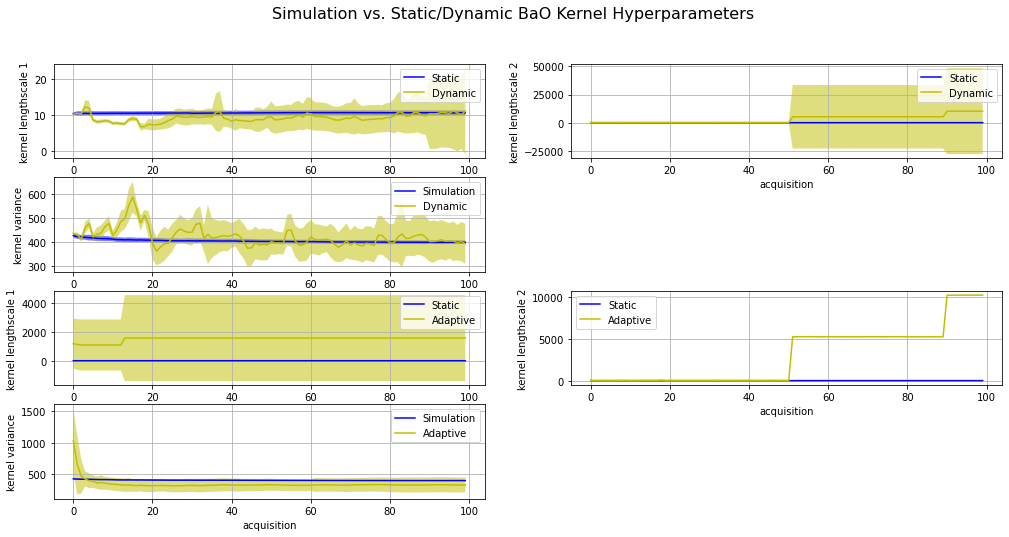

In [220]:
x_acquisitions = np.arange(0,n_acquisition)
fig = plt.figure(figsize=(17,8));
fig.suptitle("Simulation vs. Static/Dynamic BaO Kernel Hyperparameters", fontsize=16)
plt.subplot(4,2,1)
plt.plot(x_acquisitions, static_lengthscale_mean[0,:], label=r"frequency", color='b')
plt.fill_between(x_acquisitions, static_lengthscale_mean[0,:]+static_lengthscale_std[0,:],
                static_lengthscale_mean[0,:]-static_lengthscale_std[0,:], alpha=0.5, facecolor='b', label='_Hidden')
plt.plot(x_acquisitions, dynamic_lengthscale_mean[0,:], label=r"frequency", color='y')
plt.fill_between(x_acquisitions, dynamic_lengthscale_mean[0,:]+dynamic_lengthscale_std[0,:],
                dynamic_lengthscale_mean[0,:]-dynamic_lengthscale_std[0,:], alpha=0.5, facecolor='y', label='_Hidden')
# plt.ylim([-5, 50])
plt.xlabel("acquisition")
plt.ylabel("kernel lengthscale 1")
plt.legend(["Static", '_Hidden', "Dynamic", '_Hidden']);
plt.grid(visible=True)

plt.subplot(4,2,2)
plt.plot(x_acquisitions, static_lengthscale_mean[1,:], label=r"amplitude", color='b')
plt.fill_between(x_acquisitions, static_lengthscale_mean[1,:]+static_lengthscale_std[1,:],
                static_lengthscale_mean[1,:]-static_lengthscale_std[1,:], alpha=0.5, facecolor='b', label='_Hidden')
plt.plot(x_acquisitions, dynamic_lengthscale_mean[1,:], label=r"amplitude", color='y')
plt.fill_between(x_acquisitions, dynamic_lengthscale_mean[1,:]+dynamic_lengthscale_std[1,:],
                dynamic_lengthscale_mean[1,:]-dynamic_lengthscale_std[1,:], alpha=0.5, facecolor='y', label='_Hidden')
# plt.ylim([-5, 50])
plt.xlabel("acquisition")
plt.ylabel("kernel lengthscale 2")
plt.legend(["Static", '_Hidden', "Dynamic", '_Hidden']);
plt.grid(visible=True)

plt.subplot(4,2,3)
plt.plot(x_acquisitions, static_variance_mean[:,0], label=r"frequency", color='b')
plt.fill_between(x_acquisitions, static_variance_mean[:,0]+static_variance_std[:,0],
                static_variance_mean[:,0]-static_variance_std[:,0], alpha=0.5, facecolor='b', label='_Hidden')
plt.plot(x_acquisitions, dynamic_variance_mean[:,0], label=r"frequency", color='y')
plt.fill_between(x_acquisitions, dynamic_variance_mean[:,0]+dynamic_variance_std[:,0],
                dynamic_variance_mean[:,0]-dynamic_variance_std[:,0], alpha=0.5, facecolor='y', label='_Hidden')
# plt.ylim([-5, 50])
plt.xlabel("acquisition")
plt.ylabel("kernel variance")
plt.legend(["Simulation", '_Hidden', "Dynamic", '_Hidden']);
plt.grid(visible=True)

plt.subplot(4,2,5)
plt.plot(x_acquisitions, static_lengthscale_mean[0,:], label=r"frequency", color='b')
plt.fill_between(x_acquisitions, static_lengthscale_mean[0,:]+static_lengthscale_std[0,:],
                static_lengthscale_mean[0,:]-static_lengthscale_std[0,:], alpha=0.5, facecolor='b', label='_Hidden')
plt.plot(x_acquisitions, adaptive_lengthscale_mean[0,:], label=r"frequency", color='y')
plt.fill_between(x_acquisitions, adaptive_lengthscale_mean[0,:]+adaptive_lengthscale_std[0,:],
                adaptive_lengthscale_mean[0,:]-adaptive_lengthscale_std[0,:], alpha=0.5, facecolor='y', label='_Hidden')
# plt.ylim([-5, 50])
plt.xlabel("acquisition")
plt.ylabel("kernel lengthscale 1")
plt.legend(["Static", '_Hidden', "Adaptive", '_Hidden']);
plt.grid(visible=True)

plt.subplot(4,2,6)
plt.plot(x_acquisitions, static_lengthscale_mean[1,:], label=r"amplitude", color='b')
plt.fill_between(x_acquisitions, static_lengthscale_mean[1,:]+static_lengthscale_std[1,:],
                static_lengthscale_mean[1,:]-static_lengthscale_std[1,:], alpha=0.5, facecolor='b', label='_Hidden')
plt.plot(x_acquisitions, dynamic_lengthscale_mean[1,:], label=r"amplitude", color='y')
plt.fill_between(x_acquisitions, adaptive_lengthscale_mean[1,:]+adaptive_lengthscale_std[1,:],
                adaptive_lengthscale_mean[1,:]-adaptive_lengthscale_std[1,:], alpha=0.5, facecolor='y', label='_Hidden')
# plt.ylim([-5, 50])
plt.xlabel("acquisition")
plt.ylabel("kernel lengthscale 2")
plt.legend(["Static", '_Hidden', "Adaptive", '_Hidden']);
plt.grid(visible=True)

plt.subplot(4,2,7)
plt.plot(x_acquisitions, static_variance_mean[:,0], label=r"frequency", color='b')
plt.fill_between(x_acquisitions, static_variance_mean[:,0]+static_variance_std[:,0],
                static_variance_mean[:,0]-static_variance_std[:,0], alpha=0.5, facecolor='b', label='_Hidden')
plt.plot(x_acquisitions, adaptive_variance_mean[:,0], label=r"frequency", color='y')
plt.fill_between(x_acquisitions, adaptive_variance_mean[:,0]+adaptive_variance_std[:,0],
                adaptive_variance_mean[:,0]-adaptive_variance_std[:,0], alpha=0.5, facecolor='y', label='_Hidden')
# plt.ylim([-5, 50])
plt.xlabel("acquisition")
plt.ylabel("kernel variance")
plt.legend(["Simulation", '_Hidden', "Adaptive", '_Hidden']);
plt.grid(visible=True)

plt.show();

#### 1.7.3 Number of samples to converge

In [221]:
derivative_static_freq = np.gradient(static_ucb_mean[:,0])
idx_derivative_satic_freq = np.where(derivative_static_freq==0)
print("The derivative of Static Freq is: ", derivative_static_freq, "\n index where static freq plateaus: ", idx_derivative_satic_freq)

derivative_static_amp = np.gradient(static_ucb_mean[:,1])
idx_derivative_satic_amp = np.where(derivative_static_amp==0)
print("The derivative of Static Amp is: ", derivative_static_amp, "\n index where static freq plateaus: ", idx_derivative_satic_amp)

idx_plateau_static_freq = []
idx_plateau_static_amp = []
# print(np.size(idx_derivative_satic_freq), np.shape(idx_plateau_static_freq))
for p in range(0, n_acquisition):
    if derivative_static_freq[p:p+1]==0. :
        idx_plateau_static_freq = np.append(idx_plateau_static_freq,[p+1])
        # print(p, '\n ', idx_plateau_static_freq)
    if derivative_static_amp[p:p+1]==0. :
        idx_plateau_static_amp = np.append(idx_plateau_static_amp,[p+1])
        
print("The idx of first plateau for static model with length 2 sample for freq is: ", idx_plateau_static_freq[0]) 
print("The idx of first plateau static model with length 2 sample for amp is: ", idx_plateau_static_amp[0]) 

The derivative of Static Freq is:  [-0.4  0.   0.2 -0.1  0.   0.1  0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.  -0.1  0.   0.1  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0. ] 
 index where static freq plateaus:  (array([ 1,  4,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 23, 24, 25, 26, 27, 28, 30, 32, 33, 34, 35, 36, 37, 38, 39,
       40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
       57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73,
       74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90,
       91, 92, 93, 94, 95, 96, 97, 98, 99], dtype=

In [222]:
derivative_dynamic_freq = np.gradient(dynamic_ucb_mean[:,0])
idx_derivative_dynamic_freq = np.where(derivative_dynamic_freq==0)
print("The derivative of dynamic Freq is: ", derivative_dynamic_freq, "\n index where dynamic freq plateaus: ", idx_derivative_dynamic_freq)

derivative_dynamic_amp = np.gradient(dynamic_ucb_mean[:,1])
idx_derivative_dynamic_amp = np.where(derivative_dynamic_amp==0)
print("The derivative of dynamic Amp is: ", derivative_dynamic_amp, "\n index where dynamic freq plateaus: ", idx_derivative_dynamic_amp)

idx_plateau_dynamic_freq = []
idx_plateau_dynamic_amp = []
# print(np.size(idx_derivative_satic_freq), np.shape(idx_plateau_static_freq))
for p in range(0, n_acquisition):
    if derivative_dynamic_freq[p:p+1]==0. :
        idx_plateau_dynamic_freq = np.append(idx_plateau_dynamic_freq,[p+1])
        # print(p, '\n ', idx_plateau_static_freq)
    if derivative_dynamic_amp[p:p+1]==0. :
        idx_plateau_dynamic_amp = np.append(idx_plateau_dynamic_amp,[p+1])
        
print("The idx of first plateau for dynamic model with length 2 sample for freq is: ", idx_plateau_dynamic_freq[0]) 
print("The idx of first plateau dynamic model with length 2 sample for amp is: ", idx_plateau_dynamic_amp[0]) 

The derivative of dynamic Freq is:  [  0.          -0.6         -0.6         -1.8          1.5
   5.9         -0.1         -4.1         -9.8         -8.4
   6.8          6.9          2.1          1.9         -4.5
 -14.8        -10.4         11.5          8.86666667  -2.23333333
   0.9         -4.46666667  -1.81666667   7.46666667   2.85
  -1.26666667   2.7          5.16666667   4.78333333  -0.65
  -5.35        -9.41666667  -6.93333333   6.4          7.1
   1.4         -1.3         -2.2        -11.3         -9.98333333
   8.63333333   6.08333333   1.           3.45        -4.4
  -3.           5.2          1.71666667  -1.93333333   2.03333333
   6.26666667   4.45        -2.53333333  -6.01666667  -6.51666667
  -3.3          6.03333333   4.35         0.9          0.33333333
  -2.03333333 -11.31666667  -9.1          9.66666667   6.08333333
   0.4          3.68333333  -3.5         -3.6          3.9
   2.41666667  -0.33333333   0.53333333   4.38333333   4.83333333
  -1.83333333  -5.43333333  

In [223]:
idx_static_vs_dynamic_freq = idx_plateau_dynamic_freq[0] - idx_plateau_static_freq[0]
idx_static_vs_dynamic_amp = idx_plateau_dynamic_amp[0] - idx_plateau_static_amp[0]

print("the dynamic freq plateaus at sample %d after the static sample.", idx_static_vs_dynamic_freq)
print("the dynamic amp plateaus at sample %d after the static sample.", idx_static_vs_dynamic_amp)

the dynamic freq plateaus at sample %d after the static sample. -1.0
the dynamic amp plateaus at sample %d after the static sample. 0.0


In [224]:
print(np.shape(idx_plateau_static_freq),
     np.shape(idx_plateau_static_amp),
     np.shape(idx_plateau_dynamic_freq),
     np.shape(idx_plateau_dynamic_amp))

(94,) (100,) (1,) (5,)


<AxesSubplot:>

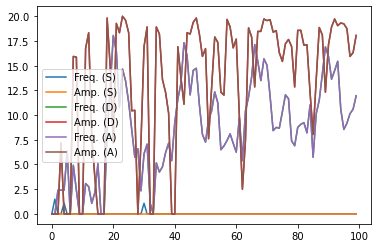

In [225]:
# number of samples to converge:
std_dev_ucb_df.plot.line()

In [226]:
std_dev_ucb_df.describe()

,Freq. (S),Amp. (S),Freq. (D),Amp. (D),Freq. (A),Amp. (A)
count,100.000000,100.0,100.000000,100.000000,100.000000,100.000000
mean,0.036507,0.0,8.712218,13.172877,8.712218,13.172877
std,0.211458,0.0,4.810285,6.930049,4.810285,6.930049
min,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.0,5.644256,9.491977,5.644256,9.491977
50%,0.000000,0.0,8.757219,16.734854,8.757219,16.734854
75%,0.000000,0.0,11.975046,18.466185,11.975046,18.466185
max,1.496663,0.0,18.053131,20.000000,18.053131,20.000000


In [227]:
std_dev_static_freq_converge = std_dev_ucb_df.loc[std_dev_ucb_df['Freq. (S)']<std_dev_ucb_df['Freq. (S)'].mean(),['Freq. (S)']].index
std_dev_static_amp_converge = std_dev_ucb_df.loc[std_dev_ucb_df['Amp. (S)']<std_dev_ucb_df['Amp. (S)'].mean(),['Amp. (S)']].index

std_dev_dynamic_freq_converge = std_dev_ucb_df.loc[std_dev_ucb_df['Freq. (D)']<std_dev_ucb_df['Freq. (D)'].mean(),['Freq. (D)']].index
std_dev_dynamic_amp_converge = std_dev_ucb_df.loc[std_dev_ucb_df['Amp. (D)']<std_dev_ucb_df['Amp. (D)'].mean(),['Amp. (D)']].index
print('std_dev_static_freq_converge \n', std_dev_static_freq_converge)
print('std_dev_static_amp_converge \n', std_dev_static_amp_converge)
print('std_dev_dynamic_freq_converge \n', std_dev_dynamic_freq_converge)
print('std_dev_dynamic_amp_converge \n', std_dev_dynamic_amp_converge)

std_dev_static_freq_converge 
 Int64Index([ 0,  2,  3,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
            19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36,
            37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
            54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70,
            71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87,
            88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
           dtype='int64')
std_dev_static_amp_converge 
 Int64Index([], dtype='int64')
std_dev_dynamic_freq_converge 
 Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 49,
            50, 55, 56, 57, 58, 59, 60, 62, 72, 74, 78, 79, 83, 85, 95],
           dtype='int64')
std_dev_dynamic_amp_converge 
 Int64Index([ 0,  1,  2,  3,  4,  5,  6,  9, 10, 13, 14, 15, 16, 17, 20, 26, 27,
            28, 29, 

In [228]:
print(np.shape(std_dev_static_freq_converge),
     np.shape(std_dev_static_amp_converge),
     np.shape(std_dev_dynamic_freq_converge),
     np.shape(std_dev_dynamic_amp_converge))

(97,) (0,) (49,) (38,)


#### 1.7.4: Comparing the Simulation with Static/Dynamic models using Normalized Mean-Squared-Error (NMSE).

$$NMSE(GP_{est}, GP_{sim})= \frac{||\mu_{est}(x)-\mu_{sim}(s)||_2^2}{||\mu_{sim}(x)||_2^2} $$

In [229]:
nmse_static_simulatinon_freq = np.square(np.subtract(static_ucb_mean[:,0], static_sample_mean[:, 0])).mean()/(np.square(static_sample_mean[:, 0])).mean()
nmse_static_simulatinon_freq = np.round(nmse_static_simulatinon_freq, 4)
print("nmse_static_simulatinon_freq: ", nmse_static_simulatinon_freq)
nmse_static_simulatinon_amp = np.square(np.subtract(static_ucb_mean[:,1], static_sample_mean[:, 1])).mean()/(np.square(static_sample_mean[:, 1])).mean()
nmse_static_simulatinon_amp = np.round(nmse_static_simulatinon_amp, 4)
print("nmse_static_simulatinon_amp: ", nmse_static_simulatinon_amp, '\n')

nmse_dynamic_simulatinon_freq = np.square(np.subtract(dynamic_ucb_mean[:,0], dynamic_sample_mean[:, 0])).mean()/(np.square(dynamic_sample_mean[:, 0])).mean()
nmse_dynamic_simulatinon_freq = np.round(nmse_dynamic_simulatinon_freq, 4)
print("nmse_dynamic_simulatinon_freq: ", nmse_dynamic_simulatinon_freq)
nmse_dynamic_simulatinon_amp = np.square(np.subtract(dynamic_ucb_mean[:,0], dynamic_sample_mean[:, 1])).mean()/(np.square(dynamic_sample_mean[:, 1])).mean()
nmse_dynamic_simulatinon_amp = np.round(nmse_dynamic_simulatinon_amp, 4)
print("nmse_dynamic_simulatinon_amp: ", nmse_dynamic_simulatinon_amp)

nmse_static_simulatinon_freq:  0.0
nmse_static_simulatinon_amp:  0.0 

nmse_dynamic_simulatinon_freq:  0.1131
nmse_dynamic_simulatinon_amp:  0.2464


In [230]:
print(np.shape(static_ucb_std))

(100, 3)


In [231]:
# Post stimulation Gamma comparison plots

postStim_gamma_df = pd.DataFrame({"Simulation S": simulation_postStimGamma_predicted.flatten('C'),
                                 "Static": static_postStimGamma_predicted.flatten('C'),
                                 "Simulation D": simulation_postStimGamma_predicted_d.flatten('C'),
                                 "Dynamic": dynamic_postStimGamma_predicted.flatten('C')})
postStim_gamma_df.head()

,Simulation S,Static,Simulation D,Dynamic
0,40.805627,39.875981,42.257704,35.527271
1,44.582308,41.201513,39.024390,42.428830
2,39.919026,40.006475,40.668245,45.998343
3,43.890067,46.653339,47.158122,37.585579
4,42.337724,46.651747,39.658537,39.514119


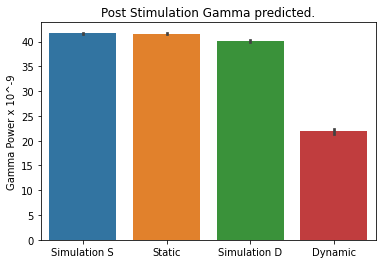

In [232]:
sns.barplot(data=postStim_gamma_df);
plt.ylabel("Gamma Power x 10^-9");
plt.title("Post Stimulation Gamma predicted.");
plt.show();

#### Next make the bayes_opt_update_state_dr()
function X_new_sample = bayes_opt_update_state_dr(objective_est, input_space, acquisition_function, acq_params, t)

[Y_mean, ~, ~, Y_uncertainty] = objective_est.predict(input_space);

switch acquisition_function
    case 'PI'
        acq_value = predicted_improvement(Y_mean, Y_uncertainty, acq_params); % TODO
    case 'EI'
        acq_value = expected_improvement(Y_mean, Y_uncertainty, acq_params); % TODO
    case 'UCB'
        acq_value = upper_confidence_bound(Y_mean, Y_uncertainty, acq_params, t);
end

[~, max_idx] = max(acq_value);

X_new_sample = input_space(max_idx,:);

end